# REINFORCE in PyTorch

Just like we did before for Q-learning, this time we'll design a PyTorch network to learn `CartPole-v0` via policy gradient (REINFORCE).

Most of the code in this notebook is taken from approximate Q-learning, so you'll find it more or less familiar and even simpler.

In [1]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

A caveat: with some versions of `pyglet`, the following cell may crash with `NameError: name 'base' is not defined`. The corresponding bug report is [here](https://github.com/pyglet/pyglet/issues/134). If you see this error, try restarting the kernel.

[ 0.0487931   0.00806361 -0.01604547  0.03624977]


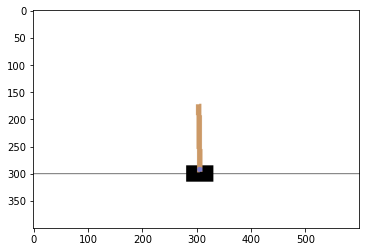

In [2]:
# env_name = 'LunarLander-v2'
env_name = 'CartPole-v1'
env = gym.make(env_name)

# gym compatibility: unwrap TimeLimit
if hasattr(env, '_max_episode_steps'):
    env = env.env

print(env.reset())
n_actions = env.action_space.n
state_dim = env.observation_space.shape

plt.imshow(env.render("rgb_array"))

# Building the network for REINFORCE

For REINFORCE algorithm, we'll need a model that predicts action probabilities given states.

For numerical stability, please __do not include the softmax layer into your network architecture__.
We'll use softmax or log-softmax where appropriate.

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [15]:
# Build a simple neural network that predicts policy logits. 
# Keep it simple: CartPole isn't worth deep architectures.
hidden = 64

policy_model = nn.Sequential(
    torch.nn.Linear(state_dim[0], hidden),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden, hidden),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden, n_actions)
)
value_model = nn.Sequential(
    torch.nn.Linear(state_dim[0], hidden),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden, hidden),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden, 1),
    torch.nn.Flatten(start_dim=0)
)

#### Predict function

Note: output value of this function is not a torch tensor, it's a numpy array.
So, here gradient calculation is not needed.
<br>
Use [no_grad](https://pytorch.org/docs/stable/autograd.html#torch.autograd.no_grad)
to suppress gradient calculation.
<br>
Also, `.detach()` (or legacy `.data` property) can be used instead, but there is a difference:
<br>
With `.detach()` computational graph is built but then disconnected from a particular tensor,
so `.detach()` should be used if that graph is needed for backprop via some other (not detached) tensor;
<br>
In contrast, no graph is built by any operation in `no_grad()` context, thus it's preferable here.

In [5]:
def predict_probs(states):
    """ 
    Predict action probabilities given states.
    :param states: numpy array of shape [batch, state_shape]
    :returns: numpy array of shape [batch, n_actions]
    """
    states = torch.Tensor(states)
    with torch.no_grad():
        logits = policy_model(states)
        probs = F.softmax(logits, dim=-1).numpy()
        
    # convert states, compute logits, use softmax to get probability
    return probs

In [16]:
def predict_v(states):
    """ 
    Predict action probabilities given states.
    :param states: numpy array of shape [batch, state_shape]
    :returns: numpy array of shape [batch, n_actions]
    """
    states = torch.Tensor(states)
    with torch.no_grad():
        v = value_model(states).numpy()
        
    return v

In [6]:
test_states = np.array([env.reset() for _ in range(5)])
test_probas = predict_probs( test_states)
assert isinstance(test_probas, np.ndarray), \
    "you must return np array and not %s" % type(test_probas)
assert tuple(test_probas.shape) == (test_states.shape[0], env.action_space.n), \
    "wrong output shape: %s" % np.shape(test_probas)
assert np.allclose(np.sum(test_probas, axis=1), 1), "probabilities do not sum to 1"

In [24]:
s = env.reset()
done = False
while not done:
    a = predict_probs([s])
    print(a)
    a = np.argmax(a)
    s,r, done, info = env.step(a)
    
# v = predict_v( [s, s])
# , v

[[0.61720204 0.38279793]]
[[0.186247 0.813753]]
[[0.63224053 0.3677595 ]]
[[0.19641896 0.803581  ]]
[[0.6412816 0.3587184]]
[[0.20247053 0.79752946]]
[[0.64481366 0.35518637]]
[[0.20431165 0.79568833]]
[[0.6430667 0.3569334]]
[[0.20208696 0.797913  ]]
[[0.6360313  0.36396873]]
[[0.19564132 0.80435866]]
[[0.6234664 0.3765336]]
[[0.1851851  0.81481487]]
[[0.6049102  0.39508975]]
[[0.17120805 0.828792  ]]
[[0.57970434 0.42029563]]
[[0.15416715 0.8458328 ]]
[[0.5470533 0.4529467]]
[[0.13464646 0.8653535 ]]
[[0.5061551  0.49384493]]
[[0.11244524 0.8875548 ]]
[[0.4559338 0.5440662]]
[[0.8281158  0.17188413]]
[[0.42370263 0.57629734]]
[[0.8099875  0.19001245]]
[[0.39432508 0.60567486]]
[[0.7914293  0.20857072]]
[[0.36711475 0.6328853 ]]
[[0.77178377 0.22821626]]
[[0.34083107 0.65916884]]
[[0.751156   0.24884401]]
[[0.3126166  0.68738335]]
[[0.7284064  0.27159357]]
[[0.2850813  0.71491873]]
[[0.7036469 0.2963531]]
[[0.25724262 0.7427574 ]]
[[0.67619234 0.32380772]]
[[0.2293376 0.7706624]]
[[0.

[[0.48169702 0.518303  ]]
[[0.8115921  0.18840788]]
[[0.4830828  0.51691717]]
[[0.81354624 0.18645377]]
[[0.4877809 0.5122191]]
[[0.8172894  0.18271062]]
[[0.4961761  0.50382394]]
[[0.82280403 0.17719595]]
[[0.50843036 0.49156958]]
[[0.13654464 0.86345536]]
[[0.49933267 0.50066733]]
[[0.8219959  0.17800413]]
[[0.5063754  0.49362466]]
[[0.1345067  0.86549324]]
[[0.49206284 0.5079372 ]]
[[0.81624424 0.18375579]]
[[0.4937696  0.50623035]]
[[0.81858134 0.18141864]]
[[0.4993369 0.5006631]]
[[0.8226482  0.17735176]]
[[0.5088527  0.49114725]]
[[0.13625227 0.8637477 ]]
[[0.4970337 0.5029664]]
[[0.81920487 0.18079515]]
[[0.5013109 0.4986892]]
[[0.13143483 0.8685652 ]]
[[0.48411688 0.5158831 ]]
[[0.81076944 0.18923064]]
[[0.48275486 0.5172451 ]]
[[0.81194806 0.18805192]]
[[0.4849865 0.5150135]]
[[0.814778   0.18522201]]
[[0.49082258 0.50917745]]
[[0.81924766 0.18075226]]
[[0.50036556 0.49963444]]
[[0.13205278 0.8679473 ]]
[[0.48833492 0.51166505]]
[[0.8156096  0.18439049]]
[[0.49215448 0.5078455

[[0.17787834 0.8221217 ]]
[[0.57760644 0.42239353]]
[[0.1891948  0.81080526]]
[[0.59039694 0.4096031 ]]
[[0.19658181 0.80341816]]
[[0.59727234 0.4027277 ]]
[[0.19988953 0.80011046]]
[[0.59853643 0.40146354]]
[[0.19908026 0.8009197 ]]
[[0.59427834 0.4057217 ]]
[[0.1942087  0.80579126]]
[[0.58447486 0.41552517]]
[[0.18542162 0.81457835]]
[[0.56875    0.43125004]]
[[0.17297608 0.8270239 ]]
[[0.546589   0.45341098]]
[[0.15727063 0.84272933]]
[[0.5173742  0.48262584]]
[[0.13897058 0.8610294 ]]
[[0.48048103 0.51951903]]
[[0.7969556  0.20304437]]
[[0.46060354 0.53939646]]
[[0.78797626 0.21202375]]
[[0.4444168 0.5555832]]
[[0.7804995  0.21950053]]
[[0.431428 0.568572]]
[[0.7744331  0.22556694]]
[[0.42103317 0.5789668 ]]
[[0.76968414 0.2303159 ]]
[[0.41262332 0.5873767 ]]
[[0.7661667  0.23383333]]
[[0.40603158 0.5939684 ]]
[[0.7638062  0.23619378]]
[[0.40121108 0.5987889 ]]
[[0.76254314 0.23745689]]
[[0.3984728 0.6015272]]
[[0.7623341  0.23766588]]
[[0.39770058 0.60229945]]
[[0.7631527  0.23684

[[0.14171931 0.85828066]]
[[0.5049673  0.49503276]]
[[0.137364   0.86263597]]
[[0.49437183 0.5056282 ]]
[[0.845653 0.154347]]
[[0.5023465 0.4976535]]
[[0.13632792 0.86367214]]
[[0.49415326 0.50584674]]
[[0.84585 0.15415]]
[[0.5048563  0.49514368]]
[[0.13834436 0.86165565]]
[[0.49904156 0.50095844]]
[[0.84871745 0.15128253]]
[[0.51296115 0.4870388 ]]
[[0.14344558 0.8565544 ]]
[[0.51018625 0.4898138 ]]
[[0.1408475 0.8591525]]
[[0.50270474 0.4972952 ]]
[[0.13601029 0.8639898 ]]
[[0.49050128 0.5094988 ]]
[[0.8404609 0.1595391]]
[[0.49834853 0.5016514 ]]
[[0.84632444 0.15367559]]
[[0.5140429  0.48595712]]
[[0.14361657 0.85638344]]
[[0.5120249  0.48797515]]
[[0.14172085 0.85827917]]
[[0.5053056  0.49469447]]
[[0.13733946 0.8626606 ]]
[[0.4939447 0.5060553]]
[[0.8399836  0.16001639]]
[[0.502495   0.49750498]]
[[0.1364348  0.86356527]]
[[0.49376342 0.5062366 ]]
[[0.8399117  0.16008826]]
[[0.50492406 0.49507597]]
[[0.13837856 0.8616214 ]]
[[0.4988459 0.5011541]]
[[0.8427105  0.15728955]]
[[0.51

[[0.14629593 0.8537041 ]]
[[0.48923627 0.51076376]]
[[0.8046062  0.19539379]]
[[0.4967065 0.5032936]]
[[0.81077725 0.18922272]]
[[0.5111134  0.48888662]]
[[0.153313   0.84668696]]
[[0.5072338  0.49276623]]
[[0.14996296 0.8500371 ]]
[[0.49784628 0.5021537 ]]
[[0.81013197 0.18986799]]
[[0.5082771  0.49172288]]
[[0.15077214 0.84922785]]
[[0.5003808  0.49961922]]
[[0.14520964 0.85479033]]
[[0.48683956 0.51316035]]
[[0.8031139  0.19688609]]
[[0.49286735 0.50713265]]
[[0.8085554  0.19144456]]
[[0.50572544 0.4942745 ]]
[[0.14962788 0.85037214]]
[[0.500149   0.49985102]]
[[0.14537072 0.85462934]]
[[0.48888007 0.51111996]]
[[0.8050811  0.19491889]]
[[0.49719438 0.5028056 ]]
[[0.8118418  0.18815817]]
[[0.5124052  0.48759484]]
[[0.15381025 0.84618974]]
[[0.5093111  0.49068892]]
[[0.15089878 0.8491012 ]]
[[0.50071067 0.49928927]]
[[0.14494023 0.85505974]]
[[0.48644695 0.513553  ]]
[[0.80294967 0.19705029]]
[[0.4917152 0.5082848]]
[[0.8082561  0.19174387]]
[[0.50375855 0.4962414 ]]
[[0.14802222 0.8

[[0.13807927 0.8619207 ]]
[[0.49090505 0.50909495]]
[[0.8245533  0.17544669]]
[[0.4954075  0.50459254]]
[[0.8291002  0.17089978]]
[[0.50614774 0.49385223]]
[[0.13996685 0.86003315]]
[[0.497519   0.50248104]]
[[0.82973725 0.17026275]]
[[0.50717026 0.4928297 ]]
[[0.14028534 0.8597146 ]]
[[0.49749073 0.50250924]]
[[0.8293856  0.17061447]]
[[0.5061031  0.49389693]]
[[0.13962895 0.8603711 ]]
[[0.49536917 0.50463086]]
[[0.8280203  0.17197971]]
[[0.5028862 0.4971138]]
[[0.13795686 0.86204314]]
[[0.49098876 0.5090112 ]]
[[0.825499   0.17450097]]
[[0.49724442 0.5027556 ]]
[[0.83085436 0.16914561]]
[[0.5097582  0.49024183]]
[[0.14234892 0.85765105]]
[[0.5029707 0.4970293]]
[[0.13763884 0.8623612 ]]
[[0.4887736 0.5112264]]
[[0.823636 0.176364]]
[[0.4926995  0.50730056]]
[[0.8279031  0.17209694]]
[[0.50279737 0.4972026 ]]
[[0.13866635 0.86133367]]
[[0.49344465 0.5065553 ]]
[[0.82782465 0.1721753 ]]
[[0.50227344 0.49772653]]
[[0.13821693 0.8617831 ]]
[[0.4916531  0.50834686]]
[[0.8265264  0.1734736

[[0.48312685 0.5168731 ]]
[[0.8209955  0.17900443]]
[[0.4875313 0.5124687]]
[[0.8255159  0.17448407]]
[[0.4971203 0.5028797]]
[[0.83245355 0.16754642]]
[[0.51219344 0.48780653]]
[[0.13906252 0.8609375 ]]
[[0.50722986 0.49277008]]
[[0.13507347 0.86492646]]
[[0.49415565 0.50584435]]
[[0.8262196  0.17378041]]
[[0.49812675 0.5018732 ]]
[[0.8304521  0.16954798]]
[[0.507408 0.492592]]
[[0.13557664 0.86442333]]
[[0.49678385 0.50321615]]
[[0.8285797  0.17142032]]
[[0.50324124 0.49675873]]
[[0.13291726 0.8670828 ]]
[[0.4897135 0.5102865]]
[[0.82375026 0.1762498 ]]
[[0.49311638 0.50688356]]
[[0.82769877 0.17230117]]
[[0.5017038  0.49829617]]
[[0.13250042 0.8674996 ]]
[[0.490244 0.509756]]
[[0.8249128  0.17508724]]
[[0.4957028  0.50429714]]
[[0.8298557  0.17014425]]
[[0.50638723 0.49361277]]
[[0.13521168 0.86478835]]
[[0.4971184 0.5028816]]
[[0.8292989  0.17070113]]
[[0.50491625 0.4950838 ]]
[[0.13390103 0.866099  ]]
[[0.4927489 0.5072511]]
[[0.8258578  0.17414218]]
[[0.49756682 0.50243324]]
[[0.

[[0.5017231  0.49827686]]
[[0.128414   0.87158597]]
[[0.489144 0.510856]]
[[0.8228661  0.17713387]]
[[0.49312276 0.50687724]]
[[0.826966   0.17303403]]
[[0.5019485 0.4980515]]
[[0.1287058 0.8712942]]
[[0.49042308 0.509577  ]]
[[0.8239784  0.17602152]]
[[0.49547613 0.5045239 ]]
[[0.8286032  0.17139679]]
[[0.50539595 0.4946041 ]]
[[0.13060462 0.8693954 ]]
[[0.4950953 0.5049046]]
[[0.826859   0.17314097]]
[[0.5014509 0.4985491]]
[[0.12800375 0.8719962 ]]
[[0.48746547 0.51253456]]
[[0.821378   0.17862195]]
[[0.49000782 0.5099922 ]]
[[0.8247662  0.17523383]]
[[0.49733064 0.50266933]]
[[0.83048385 0.16951618]]
[[0.50933415 0.49066582]]
[[0.13306862 0.8669313 ]]
[[0.5014341  0.49856597]]
[[0.12761448 0.8723855 ]]
[[0.48510805 0.514892  ]]
[[0.8189865  0.18101354]]
[[0.48509574 0.5149042 ]]
[[0.821112   0.17888805]]
[[0.4897622 0.5102378]]
[[0.8255589  0.17444113]]
[[0.49918103 0.50081897]]
[[0.83227336 0.16772664]]
[[0.5130999  0.48690003]]
[[0.13545614 0.8645439 ]]
[[0.5072023 0.4927976]]
[[

[[0.5076471 0.4923529]]
[[0.13129248 0.8687075 ]]
[[0.50031626 0.49968374]]
[[0.12618354 0.87381643]]
[[0.4848725  0.51512754]]
[[0.8184738  0.18152615]]
[[0.4852621  0.51473796]]
[[0.82071    0.17929001]]
[[0.4902315 0.5097685]]
[[0.825385   0.17461501]]
[[0.49982762 0.5001723 ]]
[[0.8323623  0.16763772]]
[[0.5133629  0.48663715]]
[[0.13466117 0.86533886]]
[[0.5075054  0.49249455]]
[[0.13025074 0.86974925]]
[[0.4939269 0.5060731]]
[[0.82449085 0.17550918]]
[[0.49649364 0.5035064 ]]
[[0.8278229  0.17217705]]
[[0.50346535 0.4965346 ]]
[[0.12822597 0.871774  ]]
[[0.49085248 0.5091475 ]]
[[0.8230601 0.1769399]]
[[0.4942951 0.5057049]]
[[0.82690114 0.17309882]]
[[0.50207806 0.49792197]]
[[0.12760344 0.8723966 ]]
[[0.49020255 0.5097975 ]]
[[0.82301325 0.17698671]]
[[0.4943975 0.5056026]]
[[0.8272819  0.17271811]]
[[0.50294197 0.49705803]]
[[0.12817486 0.8718251 ]]
[[0.49185076 0.50814927]]
[[0.82429606 0.17570397]]
[[0.49682313 0.50317687]]
[[0.82898855 0.17101148]]
[[0.50618285 0.49381718]

[[0.823781 0.176219]]
[[0.4956665  0.50433356]]
[[0.8276519  0.17234811]]
[[0.50357205 0.49642795]]
[[0.12811606 0.8718839 ]]
[[0.4918606 0.5081394]]
[[0.82396525 0.17603473]]
[[0.49619463 0.50380534]]
[[0.82827103 0.17172898]]
[[0.5048815 0.4951185]]
[[0.12893432 0.8710657 ]]
[[0.49397638 0.5060236 ]]
[[0.82555974 0.17444026]]
[[0.4991614 0.5008387]]
[[0.83030665 0.16969334]]
[[0.50876355 0.49123645]]
[[0.13117269 0.86882734]]
[[0.49886328 0.5011367 ]]
[[0.8287872  0.17121279]]
[[0.5051641 0.4948359]]
[[0.12871669 0.87128335]]
[[0.49190253 0.5080975 ]]
[[0.8233342  0.17666581]]
[[0.49470377 0.5052962 ]]
[[0.82678264 0.17321734]]
[[0.50183547 0.49816456]]
[[0.12705937 0.8729406 ]]
[[0.48931342 0.5106866 ]]
[[0.82209325 0.17790674]]
[[0.4927793  0.50722075]]
[[0.8259373  0.17406276]]
[[0.50052017 0.4994798 ]]
[[0.12645486 0.87354517]]
[[0.48856196 0.511438  ]]
[[0.8218882  0.17811173]]
[[0.49256986 0.50743014]]
[[0.82604766 0.17395239]]
[[0.50085706 0.49914297]]
[[0.12671682 0.8732832 ]

[[0.8314221  0.16857795]]
[[0.51133096 0.48866904]]
[[0.1327612 0.8672389]]
[[0.5033452  0.49665475]]
[[0.1272637  0.87273633]]
[[0.4875223  0.51247764]]
[[0.8196602  0.18033984]]
[[0.48759893 0.5124011 ]]
[[0.8214658  0.17853428]]
[[0.49194893 0.508051  ]]
[[0.82580036 0.17419967]]
[[0.5005474  0.49945256]]
[[0.12649228 0.8735077 ]]
[[0.48939744 0.51060253]]
[[0.8226999  0.17730004]]
[[0.49421364 0.5057864 ]]
[[0.82729465 0.17270535]]
[[0.50331897 0.49668106]]
[[0.1280524 0.8719475]]
[[0.49278036 0.5072196 ]]
[[0.82497704 0.17502296]]
[[0.49828824 0.5017117 ]]
[[0.8299072  0.17009284]]
[[0.50817955 0.49182045]]
[[0.13079317 0.8692068 ]]
[[0.49854204 0.501458  ]]
[[0.82867694 0.17132306]]
[[0.5050858  0.49491414]]
[[0.12860847 0.8713915 ]]
[[0.49205434 0.50794566]]
[[0.82349634 0.17650364]]
[[0.4950785  0.50492156]]
[[0.8270568 0.1729432]]
[[0.5024314  0.49756852]]
[[0.12730813 0.8726919 ]]
[[0.49013472 0.5098653 ]]
[[0.82265645 0.1773436 ]]
[[0.4938359 0.506164 ]]
[[0.82661784 0.17338

[[0.8207901 0.1792099]]
[[0.4900165 0.5099835]]
[[0.8235821  0.17641784]]
[[0.4960874 0.5039126]]
[[0.8288556  0.17114437]]
[[0.5064748  0.49352524]]
[[0.12986782 0.87013215]]
[[0.497279 0.502721]]
[[0.8281097  0.17189032]]
[[0.5042218 0.4957782]]
[[0.12813303 0.871867  ]]
[[0.49155763 0.50844234]]
[[0.82333624 0.17666382]]
[[0.49492627 0.5050737 ]]
[[0.82708704 0.17291293]]
[[0.5026104  0.49738958]]
[[0.12738274 0.8726173 ]]
[[0.4906401 0.5093599]]
[[0.8230796  0.17692044]]
[[0.4946711  0.50532895]]
[[0.8272116  0.17278844]]
[[0.5030043  0.49699566]]
[[0.12769108 0.87230897]]
[[0.49168676 0.50831324]]
[[0.8239804  0.17601968]]
[[0.49638993 0.50361   ]]
[[0.8284731  0.17152691]]
[[0.50543153 0.49456844]]
[[0.12909868 0.87090135]]
[[0.49487612 0.50512385]]
[[0.8261681 0.1738319]]
[[0.50041413 0.49958584]]
[[0.12590225 0.87409776]]
[[0.48626554 0.51373446]]
[[0.81967866 0.18032132]]
[[0.48787552 0.5121245 ]]
[[0.8223506  0.17764933]]
[[0.49395272 0.5060472 ]]
[[0.82757294 0.17242701]]
[[

[[0.5024262  0.49757388]]
[[0.12666374 0.87333626]]
[[0.4862629  0.51373714]]
[[0.81886536 0.1811347 ]]
[[0.48587254 0.51412743]]
[[0.82040703 0.17959289]]
[[0.4897659 0.5102341]]
[[0.82439274 0.17560725]]
[[0.49802533 0.5019747 ]]
[[0.83077407 0.16922599]]
[[0.5104557  0.48954427]]
[[0.13236299 0.86763704]]
[[0.50338656 0.49661344]]
[[0.12736015 0.87263983]]
[[0.4884661  0.51153386]]
[[0.82063323 0.17936674]]
[[0.48952574 0.5104743 ]]
[[0.8229517  0.17704837]]
[[0.4947889 0.5052112]]
[[0.827786   0.17221403]]
[[0.50434536 0.4956547 ]]
[[0.12860292 0.87139714]]
[[0.49427354 0.50572646]]
[[0.8260221  0.17397794]]
[[0.5002754  0.49972472]]
[[0.12590878 0.8740912 ]]
[[0.48658338 0.51341665]]
[[0.82003206 0.17996795]]
[[0.4886812 0.5113188]]
[[0.82301515 0.17698485]]
[[0.49520767 0.50479233]]
[[0.82849056 0.17150943]]
[[0.50589937 0.49410057]]
[[0.12961881 0.87038124]]
[[0.4969918 0.5030082]]
[[0.8280678 0.1719323]]
[[0.50421375 0.49578628]]
[[0.12818679 0.87181324]]
[[0.4918271  0.5081728

[[0.8307306 0.1692694]]
[[0.510243   0.48975697]]
[[0.1321271  0.86787295]]
[[0.50261414 0.4973859 ]]
[[0.12683558 0.87316436]]
[[0.4871187 0.5128813]]
[[0.81965953 0.18034045]]
[[0.487514 0.512486]]
[[0.8215907  0.17840925]]
[[0.49218395 0.5078161 ]]
[[0.82600725 0.1739928 ]]
[[0.50102764 0.4989724 ]]
[[0.12669884 0.8733012 ]]
[[0.49016538 0.50983465]]
[[0.82325846 0.17674148]]
[[0.4952781  0.50472194]]
[[0.82799757 0.1720024 ]]
[[0.50469583 0.49530414]]
[[0.1287455 0.8712545]]
[[0.49449334 0.50550663]]
[[0.8260874  0.17391258]]
[[0.5003695 0.4996306]]
[[0.12591533 0.87408465]]
[[0.4865532  0.51344675]]
[[0.81999254 0.18000746]]
[[0.48853642 0.51146364]]
[[0.82286257 0.17713743]]
[[0.4949215 0.5050785]]
[[0.8282656  0.17173435]]
[[0.505475   0.49452496]]
[[0.12934378 0.8706562 ]]
[[0.4964178 0.5035823]]
[[0.8276691  0.17233092]]
[[0.5034751  0.49652478]]
[[0.1277434  0.87225664]]
[[0.49090517 0.5090948 ]]
[[0.8229835  0.17701648]]
[[0.4943497  0.50565034]]
[[0.82678354 0.17321646]]
[[

[[0.4908858  0.50911415]]
[[0.82345736 0.17654267]]
[[0.4954351 0.5045649]]
[[0.82788134 0.17211865]]
[[0.50430524 0.49569485]]
[[0.12852429 0.8714757 ]]
[[0.49355638 0.5064436 ]]
[[0.8253421  0.17465791]]
[[0.49887455 0.50112545]]
[[0.83015686 0.16984315]]
[[0.5085909  0.49140918]]
[[0.13096762 0.8690324 ]]
[[0.49878857 0.5012114 ]]
[[0.82874364 0.17125629]]
[[0.50517386 0.4948262 ]]
[[0.12860902 0.87139094]]
[[0.4919856  0.50801444]]
[[0.8233835  0.17661646]]
[[0.49485114 0.50514895]]
[[0.8268532  0.17314678]]
[[0.5020395  0.49796054]]
[[0.12705263 0.8729474 ]]
[[0.4895682  0.51043177]]
[[0.8222366  0.17776343]]
[[0.49308038 0.5069196 ]]
[[0.82609624 0.17390384]]
[[0.5008643  0.49913573]]
[[0.12652057 0.8734794 ]]
[[0.48895413 0.51104593]]
[[0.82210565 0.17789432]]
[[0.49300516 0.50699484]]
[[0.82627565 0.17372441]]
[[0.5013209  0.49867907]]
[[0.12684572 0.8731543 ]]
[[0.48994893 0.51005113]]
[[0.8229317  0.17706828]]
[[0.49455807 0.50544196]]
[[0.8274013  0.17259866]]
[[0.5034654  0

[[0.8300133  0.16998677]]
[[0.50838965 0.4916104 ]]
[[0.13091318 0.86908686]]
[[0.4988231  0.50117683]]
[[0.8288652  0.17113486]]
[[0.5054438 0.4945562]]
[[0.12880749 0.8711925 ]]
[[0.492497 0.507503]]
[[0.8237954  0.17620464]]
[[0.49561575 0.5043842 ]]
[[0.8274033 0.1725967]]
[[0.5030754  0.49692458]]
[[0.1276616  0.87233835]]
[[0.4908999  0.50910014]]
[[0.82316494 0.17683506]]
[[0.4947401  0.50525993]]
[[0.8271943  0.17280568]]
[[0.50289166 0.49710837]]
[[0.12766735 0.87233263]]
[[0.49139675 0.50860333]]
[[0.8237488  0.17625119]]
[[0.4959226  0.50407743]]
[[0.8281539  0.17184606]]
[[0.50478226 0.4952177 ]]
[[0.12878603 0.87121403]]
[[0.4940358 0.5059642]]
[[0.82562363 0.17437635]]
[[0.49936897 0.500631  ]]
[[0.83044565 0.16955434]]
[[0.50911295 0.4908871 ]]
[[0.13126312 0.8687369 ]]
[[0.49935204 0.50064796]]
[[0.82908434 0.17091566]]
[[0.5057927  0.49420738]]
[[0.12895545 0.8710445 ]]
[[0.49267524 0.50732476]]
[[0.8238268 0.1761732]]
[[0.49562883 0.50437117]]
[[0.82733905 0.17266098]

[[0.82044065 0.17955935]]
[[0.4899146 0.5100854]]
[[0.824592   0.17540802]]
[[0.49842232 0.5015776 ]]
[[0.8310982  0.16890188]]
[[0.5110928 0.4889072]]
[[0.13277254 0.86722744]]
[[0.5042797  0.49572033]]
[[0.12789445 0.87210554]]
[[0.48963603 0.51036394]]
[[0.82139516 0.17860483]]
[[0.491001 0.508999]]
[[0.8239673  0.17603278]]
[[0.49660546 0.50339454]]
[[0.82897127 0.17102878]]
[[0.5065464  0.49345353]]
[[0.12986481 0.8701352 ]]
[[0.49691233 0.50308764]]
[[0.827729   0.17227101]]
[[0.5034149  0.49658504]]
[[0.1276619  0.87233806]]
[[0.49029705 0.509703  ]]
[[0.8223954  0.17760466]]
[[0.49318692 0.5068131 ]]
[[0.82589424 0.17410569]]
[[0.5003558  0.49964425]]
[[0.12613824 0.87386173]]
[[0.48782223 0.51217777]]
[[0.82119083 0.1788092 ]]
[[0.49122104 0.50877887]]
[[0.8249556 0.1750444]]
[[0.49885416 0.50114584]]
[[0.8310659  0.16893408]]
[[0.51085293 0.489147  ]]
[[0.132535 0.867465]]
[[0.5033682  0.49663183]]
[[0.12730816 0.8726918 ]]
[[0.48803782 0.5119622 ]]
[[0.8202015  0.17979845]]


[[0.5032348 0.4967652]]
[[0.12798864 0.87201136]]
[[0.49272162 0.5072784 ]]
[[0.8249472  0.17505287]]
[[0.4982512 0.5017488]]
[[0.82988757 0.17011246]]
[[0.5081611 0.4918389]]
[[0.13076252 0.86923754]]
[[0.49853957 0.5014604 ]]
[[0.8286748  0.17132518]]
[[0.50509727 0.49490273]]
[[0.12859376 0.87140626]]
[[0.49207795 0.5079221 ]]
[[0.82351    0.17648998]]
[[0.49511275 0.5048873 ]]
[[0.8270736 0.1729264]]
[[0.50247526 0.4975248 ]]
[[0.12731019 0.87268984]]
[[0.49018717 0.50981283]]
[[0.82268596 0.17731403]]
[[0.49389637 0.50610363]]
[[0.8266488  0.17335123]]
[[0.5018958  0.49810418]]
[[0.12709856 0.87290144]]
[[0.49022415 0.5097758 ]]
[[0.8229691  0.17703094]]
[[0.49454388 0.5054561 ]]
[[0.82727295 0.17272702]]
[[0.50316393 0.49683604]]
[[0.12786905 0.87213093]]
[[0.49213848 0.5078615 ]]
[[0.82438487 0.17561518]]
[[0.49714643 0.50285363]]
[[0.82904553 0.17095445]]
[[0.5065124  0.49348757]]
[[0.12978081 0.8702192 ]]
[[0.49630985 0.50369024]]
[[0.82715684 0.17284317]]
[[0.50223696 0.49776

[[0.12644431 0.87355566]]
[[0.48694894 0.51305103]]
[[0.8198782  0.18012173]]
[[0.488213   0.51178694]]
[[0.82235676 0.1776432 ]]
[[0.49384755 0.50615245]]
[[0.8273617  0.17263833]]
[[0.50365096 0.49634907]]
[[0.12828633 0.8717137 ]]
[[0.49380797 0.5061921 ]]
[[0.82585293 0.17414702]]
[[0.5000257  0.49997434]]
[[0.12582798 0.87417203]]
[[0.486543 0.513457]]
[[0.82007116 0.17992878]]
[[0.48883387 0.5111661 ]]
[[0.82320774 0.1767922 ]]
[[0.49558604 0.504414  ]]
[[0.8287992  0.17120078]]
[[0.5064978 0.4935022]]
[[0.12999552 0.87000453]]
[[0.49782503 0.502175  ]]
[[0.8286469  0.17135312]]
[[0.50530154 0.49469846]]
[[0.12882699 0.871173  ]]
[[0.49319586 0.5068042 ]]
[[0.8245572  0.17544283]]
[[0.4971613  0.50283873]]
[[0.8286249  0.17137513]]
[[0.5054947  0.49450526]]
[[0.12905645 0.87094355]]
[[0.4942422  0.50575787]]
[[0.8255234  0.17447661]]
[[0.49907744 0.50092256]]
[[0.8300685  0.16993144]]
[[0.5083187  0.49168125]]
[[0.13071847 0.8692816 ]]
[[0.4980368  0.50196326]]
[[0.8281089  0.171

[[0.4891822 0.5108178]]
[[0.82205766 0.17794226]]
[[0.49279445 0.50720555]]
[[0.8259609  0.17403919]]
[[0.50066745 0.49933258]]
[[0.12639648 0.87360346]]
[[0.48883778 0.5111622 ]]
[[0.8220642  0.17793575]]
[[0.49296266 0.50703734]]
[[0.8262706  0.17372942]]
[[0.5013476  0.49865237]]
[[0.12683745 0.87316257]]
[[0.49004206 0.50995797]]
[[0.82300735 0.17699257]]
[[0.49471653 0.5052835 ]]
[[0.82750857 0.17249145]]
[[0.50368977 0.4963102 ]]
[[0.12817633 0.87182367]]
[[0.49302495 0.50697505]]
[[0.825056   0.17494392]]
[[0.4984098 0.5015902]]
[[0.8299091  0.17009091]]
[[0.50817776 0.4918223 ]]
[[0.13071746 0.86928254]]
[[0.49841335 0.5015866 ]]
[[0.8285342  0.17146581]]
[[0.50482404 0.49517593]]
[[0.12839335 0.87160665]]
[[0.4916496  0.50835043]]
[[0.82318044 0.17681953]]
[[0.4945175 0.5054825]]
[[0.8266516 0.1733484]]
[[0.50169724 0.49830273]]
[[0.12683904 0.873161  ]]
[[0.4892065 0.5107935]]
[[0.8220149  0.17798509]]
[[0.49268737 0.50731254]]
[[0.8258459  0.17415416]]
[[0.50042796 0.4995719

[[0.48313186 0.5168681 ]]
[[0.8186168  0.18138318]]
[[0.48622862 0.51377136]]
[[0.8221604  0.17783956]]
[[0.49385682 0.50614315]]
[[0.8281691  0.17183086]]
[[0.5055318 0.4944682]]
[[0.12960511 0.8703949 ]]
[[0.4974675 0.5025325]]
[[0.8287011  0.17129888]]
[[0.5055395  0.49446052]]
[[0.12908071 0.8709192 ]]
[[0.49403244 0.50596756]]
[[0.82530946 0.17469056]]
[[0.49861413 0.50138587]]
[[0.8297154  0.17028466]]
[[0.5075963  0.49240363]]
[[0.13032614 0.86967385]]
[[0.4970426 0.5029574]]
[[0.8274399  0.17256011]]
[[0.5026422 0.4973578]]
[[0.12715231 0.8728477 ]]
[[0.4886144 0.5113856]]
[[0.8210161  0.17898391]]
[[0.49056458 0.5094354 ]]
[[0.8239615  0.17603847]]
[[0.49674016 0.50325984]]
[[0.8292908  0.17070921]]
[[0.5072525  0.49274752]]
[[0.13037013 0.86962986]]
[[0.4982053 0.5017947]]
[[0.8287205 0.1712795]]
[[0.50532335 0.4946767 ]]
[[0.12880981 0.87119013]]
[[0.49286532 0.5071347 ]]
[[0.82421887 0.17578116]]
[[0.4964761 0.5035239]]
[[0.8280962 0.1719038]]
[[0.50444365 0.49555635]]
[[0.

[[0.5040557  0.49594432]]
[[0.12834264 0.8716574 ]]
[[0.49303985 0.50696015]]
[[0.8249246  0.17507541]]
[[0.4980802 0.5019198]]
[[0.8295904  0.17040959]]
[[0.50750124 0.4924987 ]]
[[0.13032192 0.8696781 ]]
[[0.4973781 0.5026219]]
[[0.8278026  0.17219736]]
[[0.50341034 0.4965897 ]]
[[0.12760656 0.8723934 ]]
[[0.4898281  0.51017195]]
[[0.8219209  0.17807919]]
[[0.4922484 0.5077516]]
[[0.82515514 0.17484489]]
[[0.49893022 0.5010698 ]]
[[0.83073306 0.1692669 ]]
[[0.50999564 0.49000433]]
[[0.13193047 0.8680695 ]]
[[0.50156504 0.498435  ]]
[[0.1262243  0.87377566]]
[[0.4852567  0.51474327]]
[[0.81818223 0.18181778]]
[[0.48457614 0.5154239 ]]
[[0.8196236  0.18037638]]
[[0.48826042 0.51173955]]
[[0.8235083  0.17649175]]
[[0.49644032 0.50355965]]
[[0.8297978  0.17020217]]
[[0.50861657 0.49138346]]
[[0.13135426 0.8686458 ]]
[[0.50125134 0.49874857]]
[[0.12622331 0.8737767 ]]
[[0.48598975 0.51401025]]
[[0.8190201 0.1809799]]
[[0.48643696 0.5135631 ]]
[[0.82106537 0.17893466]]
[[0.491319   0.50868

[[0.5056881  0.49431187]]
[[0.12919788 0.87080216]]
[[0.4947423 0.5052577]]
[[0.8259371  0.17406285]]
[[0.49989274 0.5001072 ]]
[[0.8306554  0.16934456]]
[[0.5094653  0.49053472]]
[[0.13138522 0.8686148 ]]
[[0.49954015 0.50045985]]
[[0.82911104 0.17088895]]
[[0.5058193  0.49418065]]
[[0.1289018 0.8710982]]
[[0.49253926 0.5074608 ]]
[[0.8236662 0.1763338]]
[[0.4953247  0.50467527]]
[[0.8270811  0.17291887]]
[[0.50244266 0.49755737]]
[[0.12721787 0.8727822 ]]
[[0.48990843 0.51009166]]
[[0.8224087  0.17759132]]
[[0.4933638 0.5066362]]
[[0.8262241  0.17377587]]
[[0.50109535 0.49890465]]
[[0.12659623 0.8734037 ]]
[[0.48913568 0.5108643 ]]
[[0.82219017 0.17780985]]
[[0.49313933 0.50686073]]
[[0.8263209  0.17367908]]
[[0.50140816 0.4985918 ]]
[[0.12684596 0.8731541 ]]
[[0.4899886 0.5100114]]
[[0.82292575 0.17707425]]
[[0.49454847 0.5054515 ]]
[[0.827363   0.17263697]]
[[0.50340354 0.49659646]]
[[0.12799911 0.87200093]]
[[0.49261406 0.50738597]]
[[0.82475835 0.17524162]]
[[0.49786457 0.5021354

[[0.49447107 0.505529  ]]
[[0.8268188  0.17318115]]
[[0.50210184 0.4978982 ]]
[[0.1271427 0.8728573]]
[[0.49006948 0.50993055]]
[[0.8227214  0.17727864]]
[[0.49402767 0.5059723 ]]
[[0.82682407 0.17317589]]
[[0.5022761  0.49772385]]
[[0.12732968 0.8726703 ]]
[[0.49085984 0.5091402 ]]
[[0.8234553  0.17654474]]
[[0.4954477  0.50455236]]
[[0.8278993  0.17210074]]
[[0.50435495 0.49564508]]
[[0.12854055 0.8714595 ]]
[[0.49364287 0.50635713]]
[[0.82540244 0.17459753]]
[[0.49899822 0.5010018 ]]
[[0.83023715 0.16976291]]
[[0.508753   0.49124703]]
[[0.13104565 0.86895436]]
[[0.4989918 0.5010082]]
[[0.8288715  0.17112847]]
[[0.5054213  0.49457875]]
[[0.12873235 0.8712677 ]]
[[0.49228173 0.5077182 ]]
[[0.8235773  0.17642274]]
[[0.49520162 0.50479835]]
[[0.82707256 0.17292748]]
[[0.5024513  0.49754867]]
[[0.12726429 0.8727357 ]]
[[0.49004954 0.50995046]]
[[0.8225513  0.17744869]]
[[0.4936415  0.50635856]]
[[0.82644814 0.17355184]]
[[0.501517   0.49848303]]
[[0.12686296 0.873137  ]]
[[0.48971212 0.5

[[0.8220707  0.17792922]]
[[0.49331975 0.50668025]]
[[0.82714 0.17286]]
[[0.5033629  0.49663714]]
[[0.12809229 0.87190765]]
[[0.49374387 0.50625616]]
[[0.82588327 0.1741167 ]]
[[0.50017494 0.49982503]]
[[0.12586385 0.87413615]]
[[0.4869008 0.5130992]]
[[0.8204438  0.17955615]]
[[0.48948184 0.51051813]]
[[0.82361597 0.176384  ]]
[[0.49636796 0.503632  ]]
[[0.8293085  0.17069156]]
[[0.5075056  0.49249434]]
[[0.1305004 0.8694996]]
[[0.4990759 0.5009241]]
[[0.82943517 0.17056479]]
[[0.50681746 0.49318254]]
[[0.12960702 0.870393  ]]
[[0.49500614 0.5049939 ]]
[[0.82571167 0.17428833]]
[[0.49930203 0.5006979 ]]
[[0.82995474 0.17004532]]
[[0.50800925 0.4919908 ]]
[[0.13039313 0.86960685]]
[[0.49718407 0.50281596]]
[[0.827373   0.17262699]]
[[0.50250936 0.49749067]]
[[0.1269282 0.8730718]]
[[0.48819715 0.51180285]]
[[0.82078713 0.17921284]]
[[0.48984593 0.51015407]]
[[0.82339346 0.17660654]]
[[0.49569538 0.5043046 ]]
[[0.8285253  0.17147474]]
[[0.5058497  0.49415028]]
[[0.12944303 0.8705569 ]]


[[0.13023582 0.8697642 ]]
[[0.4982814  0.50171864]]
[[0.8288327  0.17116731]]
[[0.5056277  0.49437237]]
[[0.12892348 0.8710765 ]]
[[0.49339625 0.5066038 ]]
[[0.82460785 0.17539215]]
[[0.49723756 0.50276244]]
[[0.82859904 0.17140098]]
[[0.5054451  0.49455485]]
[[0.12895133 0.8710487 ]]
[[0.49406174 0.50593823]]
[[0.8253453  0.17465472]]
[[0.49875817 0.50124186]]
[[0.82981205 0.17018792]]
[[0.5078492 0.4921508]]
[[0.1303808  0.86961925]]
[[0.49740154 0.50259846]]
[[0.8276579  0.17234217]]
[[0.50310683 0.49689314]]
[[0.12731792 0.8726821 ]]
[[0.48918688 0.5108131 ]]
[[0.8214951  0.17850487]]
[[0.49125022 0.5087498 ]]
[[0.8243931  0.17560686]]
[[0.49754694 0.502453  ]]
[[0.8297677  0.17023227]]
[[0.5081909  0.49180916]]
[[0.13080071 0.8691992 ]]
[[0.49928975 0.5007102 ]]
[[0.8293671 0.1706329]]
[[0.506571   0.49342906]]
[[0.12940665 0.8705933 ]]
[[0.49429768 0.5057024 ]]
[[0.82511    0.17488998]]
[[0.4981191  0.50188094]]
[[0.82908946 0.17091052]]
[[0.5063276  0.49367237]]
[[0.12941009 0.8

[[0.12586994 0.87413   ]]
[[0.48624763 0.5137524 ]]
[[0.81969166 0.18030831]]
[[0.4879695 0.5120305]]
[[0.8224775 0.1775224]]
[[0.49419394 0.5058061 ]]
[[0.82777387 0.17222616]]
[[0.5045201  0.49547988]]
[[0.12883466 0.87116534]]
[[0.495217   0.50478303]]
[[0.82689047 0.17310952]]
[[0.5020044  0.49799562]]
[[0.12696046 0.8730395 ]]
[[0.48913413 0.5108658 ]]
[[0.8218057  0.17819433]]
[[0.49223965 0.50776035]]
[[0.82543373 0.17456625]]
[[0.4995986 0.5004013]]
[[0.8313801  0.16861986]]
[[0.5113496  0.48865038]]
[[0.13277304 0.8672269 ]]
[[0.50363255 0.49636754]]
[[0.1274168  0.87258315]]
[[0.488079 0.511921]]
[[0.82013416 0.17986579]]
[[0.48850477 0.5114952 ]]
[[0.8220762  0.17792375]]
[[0.49311647 0.50688356]]
[[0.8265638  0.17343621]]
[[0.5019882 0.4980118]]
[[0.12726317 0.87273675]]
[[0.49118155 0.50881845]]
[[0.82390237 0.17609769]]
[[0.49637982 0.5036202 ]]
[[0.82867986 0.17132011]]
[[0.5059138  0.49408618]]
[[0.12946782 0.87053216]]
[[0.49586123 0.50413877]]
[[0.8269553  0.17304471]

[[0.8307748 0.1692252]]
[[0.5097627  0.49023733]]
[[0.13168383 0.8683162 ]]
[[0.5002837  0.49971628]]
[[0.12543833 0.8745616 ]]
[[0.4829121 0.5170879]]
[[0.8163315  0.18366848]]
[[0.48085517 0.5191449 ]]
[[0.81711924 0.18288076]]
[[0.48324388 0.5167561 ]]
[[0.82022905 0.17977095]]
[[0.49009717 0.50990283]]
[[0.8258794  0.17412066]]
[[0.50128645 0.49871346]]
[[0.12723878 0.8727612 ]]
[[0.49234194 0.50765806]]
[[0.825388   0.17461197]]
[[0.4994163 0.5005837]]
[[0.83118486 0.16881514]]
[[0.5108869  0.48911303]]
[[0.13254398 0.8674561 ]]
[[0.50288576 0.4971142 ]]
[[0.12704498 0.872955  ]]
[[0.4870389  0.51296103]]
[[0.8193401  0.18065986]]
[[0.48701632 0.5129837 ]]
[[0.82114685 0.17885318]]
[[0.49131855 0.5086815 ]]
[[0.82545733 0.17454267]]
[[0.49993077 0.50006926]]
[[0.8320457  0.16795428]]
[[0.5128259 0.4871741]]
[[0.1338392 0.8661608]]
[[0.5062865 0.4937135]]
[[0.1290802  0.87091976]]
[[0.49196878 0.50803125]]
[[0.8229087  0.17709124]]
[[0.49372113 0.5062789 ]]
[[0.8257577  0.17424233]

[[0.48797816 0.5120219 ]]
[[0.820668   0.17933205]]
[[0.48982188 0.5101781 ]]
[[0.8234614  0.17653857]]
[[0.49586925 0.5041308 ]]
[[0.8287265  0.17127354]]
[[0.5062292  0.49377075]]
[[0.12974538 0.87025464]]
[[0.4970013 0.5029987]]
[[0.8279425  0.17205752]]
[[0.50390667 0.4960933 ]]
[[0.12797356 0.8720264 ]]
[[0.49119884 0.5088011 ]]
[[0.82310724 0.17689274]]
[[0.49451646 0.5054835 ]]
[[0.82683533 0.17316474]]
[[0.50214106 0.49785888]]
[[0.12713942 0.87286067]]
[[0.49010164 0.50989836]]
[[0.82273185 0.17726812]]
[[0.4940517 0.5059483]]
[[0.826827   0.17317295]]
[[0.5022907  0.49770924]]
[[0.12731281 0.8726872 ]]
[[0.49086356 0.5091365 ]]
[[0.8234471  0.17655288]]
[[0.49543875 0.5045613 ]]
[[0.8278815  0.17211847]]
[[0.5043313  0.49566874]]
[[0.12850235 0.8714977 ]]
[[0.4936022  0.50639784]]
[[0.8253642  0.17463577]]
[[0.4989377  0.50106233]]
[[0.83018744 0.16981259]]
[[0.5086694  0.49133056]]
[[0.13097306 0.86902696]]
[[0.4988813 0.5011187]]
[[0.82879007 0.17120987]]
[[0.5052795  0.494

[[0.13043758 0.86956245]]
[[0.4994455 0.5005545]]
[[0.83004695 0.16995308]]
[[0.5081127 0.4918872]]
[[0.13054258 0.8694574 ]]
[[0.49725893 0.5027411 ]]
[[0.8274364  0.17256361]]
[[0.5025659  0.49743405]]
[[0.12705208 0.87294793]]
[[0.4882453  0.51175475]]
[[0.8207053  0.17929463]]
[[0.4898951  0.51010484]]
[[0.8234315  0.17656848]]
[[0.49575502 0.504245  ]]
[[0.82859516 0.17140485]]
[[0.5059293 0.4940707]]
[[0.12958623 0.8704137 ]]
[[0.49651238 0.5034876 ]]
[[0.8275947  0.17240533]]
[[0.50322133 0.49677867]]
[[0.1276095 0.8723905]]
[[0.49030462 0.50969535]]
[[0.82249063 0.17750946]]
[[0.49339536 0.5066047 ]]
[[0.82610476 0.17389527]]
[[0.50077   0.4992301]]
[[0.1264075 0.8735925]]
[[0.48845196 0.51154804]]
[[0.82163    0.17837001]]
[[0.4920868 0.5079132]]
[[0.8255678  0.17443226]]
[[0.49996734 0.5000327 ]]
[[0.8318018  0.16819817]]
[[0.51224434 0.4877557 ]]
[[0.13336614 0.8666339 ]]
[[0.5050731 0.4949269]]
[[0.12828252 0.8717175 ]]
[[0.49009597 0.50990397]]
[[0.82150936 0.17849067]]
[[

[[0.82313156 0.17686847]]
[[0.4945744  0.50542563]]
[[0.8269374 0.1730626]]
[[0.5023311  0.49766892]]
[[0.12730952 0.8726905 ]]
[[0.4904313  0.50956875]]
[[0.82300115 0.17699888]]
[[0.4945321  0.50546783]]
[[0.827182   0.17281806]]
[[0.5029366  0.49706346]]
[[0.12773035 0.8722696 ]]
[[0.49169323 0.5083067 ]]
[[0.82403225 0.17596772]]
[[0.4964757  0.50352436]]
[[0.82857585 0.17142409]]
[[0.5056032 0.4943968]]
[[0.12926938 0.8707306 ]]
[[0.49514276 0.5048573 ]]
[[0.82638305 0.17361687]]
[[0.50078684 0.49921316]]
[[0.12617788 0.87382215]]
[[0.48675784 0.5132422 ]]
[[0.8199418  0.18005824]]
[[0.4885186  0.51148134]]
[[0.8228024  0.17719762]]
[[0.49473777 0.50526214]]
[[0.82810855 0.17189147]]
[[0.50510544 0.4948946 ]]
[[0.12919325 0.87080675]]
[[0.49586108 0.5041389 ]]
[[0.8272979  0.17270212]]
[[0.5027261  0.49727392]]
[[0.1273917 0.8726083]]
[[0.48995352 0.5100464 ]]
[[0.8223466  0.17765342]]
[[0.4931797  0.50682026]]
[[0.8260434  0.17395663]]
[[0.5006849 0.4993151]]
[[0.12640509 0.87359

[[0.82752496 0.17247504]]
[[0.5036049  0.49639514]]
[[0.12814854 0.8718515 ]]
[[0.49264583 0.5073541 ]]
[[0.8247239  0.17527612]]
[[0.49773547 0.5022645 ]]
[[0.8294264  0.17057356]]
[[0.5072     0.49280003]]
[[0.13020353 0.8697965 ]]
[[0.49711537 0.5028847 ]]
[[0.8276801  0.17231989]]
[[0.5031823  0.49681774]]
[[0.12752818 0.8724718 ]]
[[0.48963204 0.51036793]]
[[0.82182634 0.17817366]]
[[0.49208215 0.5079178 ]]
[[0.82507885 0.1749212 ]]
[[0.49879253 0.5012075 ]]
[[0.8306792  0.16932084]]
[[0.5098861  0.49011388]]
[[0.13191402 0.868086  ]]
[[0.50148374 0.49851626]]
[[0.12622342 0.87377656]]
[[0.48520473 0.5147953 ]]
[[0.81812155 0.1818784 ]]
[[0.48452777 0.51547223]]
[[0.81958187 0.18041815]]
[[0.48824844 0.51175153]]
[[0.82353926 0.17646073]]
[[0.49648866 0.5035113 ]]
[[0.8298526  0.17014739]]
[[0.5087053  0.49129465]]
[[0.13144794 0.8685521 ]]
[[0.50138575 0.49861428]]
[[0.12633847 0.8736615 ]]
[[0.4861756  0.51382434]]
[[0.8191073  0.18089269]]
[[0.4866794 0.5133206]]
[[0.82124686 0

[[0.5038612  0.49613872]]
[[0.1281978 0.8718022]]
[[0.49227092 0.5077291 ]]
[[0.8242383  0.17576163]]
[[0.49672753 0.50327253]]
[[0.8285969  0.17140312]]
[[0.5055413  0.49445865]]
[[0.12921679 0.8707832 ]]
[[0.49477097 0.50522906]]
[[0.82604975 0.17395028]]
[[0.5001016  0.49989837]]
[[0.12579802 0.874202  ]]
[[0.4857362 0.5142638]]
[[0.8191959  0.18080412]]
[[0.48704335 0.5129566 ]]
[[0.8218499  0.17815009]]
[[0.49292305 0.5070769 ]]
[[0.82697266 0.17302737]]
[[0.50296795 0.49703205]]
[[0.12801443 0.8719856 ]]
[[0.49326676 0.50673324]]
[[0.82562083 0.17437921]]
[[0.49961674 0.5003832 ]]
[[0.8310073  0.16899273]]
[[0.5103758  0.48962414]]
[[0.13215011 0.86784995]]
[[0.50165623 0.49834374]]
[[0.12628587 0.87371415]]
[[0.4850693 0.5149307]]
[[0.81789863 0.1821014 ]]
[[0.48406085 0.5159391 ]]
[[0.8191837 0.1808163]]
[[0.48743728 0.5125627 ]]
[[0.82296044 0.1770395 ]]
[[0.49537703 0.504623  ]]
[[0.8291098  0.17089021]]
[[0.5072742 0.4927258]]
[[0.13063261 0.8693674 ]]
[[0.49957386 0.5004262

[[0.12777327 0.8722267 ]]
[[0.49136126 0.5086388 ]]
[[0.82358533 0.17641467]]
[[0.49555233 0.5044477 ]]
[[0.8278044  0.17219564]]
[[0.50407135 0.4959287 ]]
[[0.12834986 0.87165016]]
[[0.49296942 0.5070306 ]]
[[0.82484996 0.17514998]]
[[0.4979238 0.5020762]]
[[0.82947075 0.17052925]]
[[0.50725704 0.492743  ]]
[[0.13018821 0.86981183]]
[[0.49704164 0.5029583 ]]
[[0.8275759  0.17242411]]
[[0.5029753  0.49702466]]
[[0.12737244 0.87262756]]
[[0.4892859 0.5107142]]
[[0.82155204 0.17844802]]
[[0.49158725 0.50841266]]
[[0.8247164 0.1752836]]
[[0.4981358  0.50186414]]
[[0.8302335  0.16976653]]
[[0.5090511  0.49094892]]
[[0.13140373 0.86859626]]
[[0.5004484  0.49955162]]
[[0.12562439 0.87437564]]
[[0.48394454 0.5160555 ]]
[[0.8173211  0.18267883]]
[[0.48289448 0.51710546]]
[[0.8186239 0.1813761]]
[[0.48629314 0.5137068 ]]
[[0.8223232  0.17767678]]
[[0.4942216  0.50577843]]
[[0.8284803  0.17151971]]
[[0.50616205 0.49383804]]
[[0.12998338 0.87001663]]
[[0.49838856 0.5016115 ]]
[[0.82934356 0.17065

[[0.81922054 0.18077941]]
[[0.48739737 0.51260257]]
[[0.8228766  0.17712346]]
[[0.49526578 0.5047343 ]]
[[0.8289848  0.17101519]]
[[0.5070627  0.49293733]]
[[0.13044536 0.8695547 ]]
[[0.4992794 0.5007205]]
[[0.82983994 0.17016001]]
[[0.50767225 0.49232778]]
[[0.13025369 0.8697464 ]]
[[0.49653465 0.5034653 ]]
[[0.82690066 0.17309935]]
[[0.5015423  0.49845767]]
[[0.12645814 0.87354183]]
[[0.48689973 0.51310027]]
[[0.8198074  0.18019262]]
[[0.4880832  0.51191676]]
[[0.8222621  0.17773788]]
[[0.49366227 0.50633776]]
[[0.8272321  0.17276785]]
[[0.5033944  0.49660555]]
[[0.12815268 0.87184733]]
[[0.49347576 0.5065242 ]]
[[0.8256343  0.17436564]]
[[0.49961156 0.5003885 ]]
[[0.83090025 0.16909973]]
[[0.5101537  0.48984632]]
[[0.13193695 0.86806303]]
[[0.50120884 0.4987911 ]]
[[0.12596144 0.8740386 ]]
[[0.48438376 0.5156162 ]]
[[0.8174639  0.18253614]]
[[0.48307884 0.5169212 ]]
[[0.8185935  0.18140648]]
[[0.48614448 0.51385546]]
[[0.8220899  0.17791009]]
[[0.49373782 0.5062622 ]]
[[0.8280804  0

[[0.48281765 0.5171823 ]]
[[0.81845725 0.18154278]]
[[0.485837 0.514163]]
[[0.82188934 0.17811064]]
[[0.4933742 0.5066258]]
[[0.82785416 0.17214581]]
[[0.5049669 0.4950331]]
[[0.12924452 0.87075555]]
[[0.49678835 0.5032117 ]]
[[0.8282532  0.17174685]]
[[0.504727 0.495273]]
[[0.12858403 0.87141603]]
[[0.49306417 0.50693583]]
[[0.82466406 0.175336  ]]
[[0.49746397 0.50253606]]
[[0.8289737  0.17102626]]
[[0.5062344 0.4937656]]
[[0.12951821 0.8704817 ]]
[[0.49543315 0.50456685]]
[[0.82639855 0.17360143]]
[[0.5007446 0.4992555]]
[[0.12606908 0.87393093]]
[[0.48638198 0.51361805]]
[[0.8196329  0.18036714]]
[[0.4877826  0.51221746]]
[[0.8222167  0.17778333]]
[[0.49365887 0.5063411 ]]
[[0.82732964 0.1726704 ]]
[[0.50363964 0.4963603 ]]
[[0.12831038 0.8716896 ]]
[[0.49397242 0.50602764]]
[[0.8260222  0.17397785]]
[[0.5003684 0.4996316]]
[[0.1260382 0.8739618]]
[[0.48707083 0.5129292 ]]
[[0.820447 0.179553]]
[[0.48961213 0.51038784]]
[[0.8237253  0.17627473]]
[[0.4965245 0.5034754]]
[[0.8294227 

[[0.49006173 0.50993836]]
[[0.82287544 0.17712454]]
[[0.49437204 0.50562793]]
[[0.82714593 0.17285407]]
[[0.50297225 0.49702775]]
[[0.12768856 0.87231153]]
[[0.49191615 0.5080839 ]]
[[0.82422113 0.17577887]]
[[0.49688166 0.50311834]]
[[0.8288533  0.17114672]]
[[0.506193 0.493807]]
[[0.12952463 0.8704754 ]]
[[0.4959219 0.5040781]]
[[0.82688135 0.17311862]]
[[0.5017654  0.49823457]]
[[0.12663539 0.8733646 ]]
[[0.48795   0.5120501]]
[[0.82081485 0.17918514]]
[[0.49008554 0.50991446]]
[[0.8237321  0.17626798]]
[[0.49642524 0.5035748 ]]
[[0.82914996 0.17085007]]
[[0.5070849  0.49291512]]
[[0.13021445 0.8697856 ]]
[[0.49817228 0.5018278 ]]
[[0.82872885 0.17127119]]
[[0.50541526 0.49458468]]
[[0.12879217 0.8712078 ]]
[[0.4930763 0.5069238]]
[[0.82437336 0.17562664]]
[[0.4968029 0.5031971]]
[[0.8283034  0.17169663]]
[[0.5048861  0.49511394]]
[[0.12863104 0.87136894]]
[[0.49336538 0.50663465]]
[[0.8248836  0.17511645]]
[[0.49790826 0.50209177]]
[[0.82926595 0.17073405]]
[[0.50682634 0.49317366]

[[0.8274307  0.17256925]]
[[0.50383776 0.49616215]]
[[0.1283693 0.8716307]]
[[0.49415714 0.5058428 ]]
[[0.8261089  0.17389113]]
[[0.5005408  0.49945918]]
[[0.12608299 0.87391704]]
[[0.48723146 0.51276857]]
[[0.8205844  0.17941558]]
[[0.48980406 0.510196  ]]
[[0.8237985  0.17620152]]
[[0.49666286 0.50333714]]
[[0.8294825  0.17051752]]
[[0.50779825 0.4922017 ]]
[[0.13069235 0.8693076 ]]
[[0.49937657 0.50062346]]
[[0.8296205  0.17037949]]
[[0.5071362  0.49286374]]
[[0.12981464 0.8701854 ]]
[[0.49535373 0.5046463 ]]
[[0.82593584 0.17406416]]
[[0.4996896 0.5003104]]
[[0.8302016  0.16979842]]
[[0.5084486  0.49155137]]
[[0.13067181 0.86932826]]
[[0.49768874 0.5023112 ]]
[[0.82770044 0.17229958]]
[[0.50309384 0.4969062 ]]
[[0.12728113 0.8727189 ]]
[[0.4888777  0.51112235]]
[[0.82118434 0.17881565]]
[[0.4906416  0.50935847]]
[[0.8239087  0.17609128]]
[[0.49662778 0.50337225]]
[[0.82912344 0.17087655]]
[[0.50694287 0.49305707]]
[[0.13008794 0.869912  ]]
[[0.49768567 0.5023143 ]]
[[0.8283112  0.1

[[0.48654068 0.5134593 ]]
[[0.82136035 0.17863968]]
[[0.49196485 0.5080352 ]]
[[0.82625496 0.17374499]]
[[0.5016045  0.49839547]]
[[0.12718397 0.872816  ]]
[[0.491434 0.508566]]
[[0.8243271  0.17567293]]
[[0.49727002 0.50273   ]]
[[0.8294561  0.17054395]]
[[0.50745946 0.4925405 ]]
[[0.13043313 0.86956686]]
[[0.49809784 0.50190216]]
[[0.8285315  0.17146848]]
[[0.50490236 0.4950977 ]]
[[0.12853627 0.8714637 ]]
[[0.4921233 0.5078767]]
[[0.82364166 0.17635839]]
[[0.49539787 0.50460213]]
[[0.82733995 0.17266008]]
[[0.5030057 0.4969943]]
[[0.12763956 0.8723604 ]]
[[0.4909746  0.50902545]]
[[0.82326937 0.17673054]]
[[0.49495903 0.505041  ]]
[[0.8273776  0.17262232]]
[[0.5032583  0.49674168]]
[[0.12787819 0.87212175]]
[[0.4919182  0.50808185]]
[[0.8241239  0.17587614]]
[[0.49660996 0.5033901 ]]
[[0.82861334 0.1713867 ]]
[[0.5056504  0.49434957]]
[[0.12927288 0.8707271 ]]
[[0.49510425 0.50489575]]
[[0.8263229  0.17367707]]
[[0.50066197 0.499338  ]]
[[0.12609062 0.87390935]]
[[0.4865437  0.51345

[[0.82572836 0.17427167]]
[[0.500308   0.49969202]]
[[0.1263025  0.87369746]]
[[0.48874202 0.51125795]]
[[0.8221305  0.17786948]]
[[0.49312988 0.50687015]]
[[0.8264945  0.17350549]]
[[0.50178415 0.49821576]]
[[0.1271657 0.8728343]]
[[0.49076086 0.50923914]]
[[0.82357144 0.17642859]]
[[0.4957378  0.50426215]]
[[0.82823694 0.17176305]]
[[0.5050406 0.4949594]]
[[0.12900652 0.8709935 ]]
[[0.49474066 0.5052593 ]]
[[0.8262214  0.17377853]]
[[0.5005346 0.4994654]]
[[0.1260808 0.8739192]]
[[0.48664886 0.5133512 ]]
[[0.8199205  0.18007948]]
[[0.488531   0.51146907]]
[[0.822884   0.17711598]]
[[0.4949095 0.5050905]]
[[0.82826906 0.17173089]]
[[0.50542176 0.4945782 ]]
[[0.12940037 0.8705996 ]]
[[0.49633002 0.50367004]]
[[0.82763493 0.17236513]]
[[0.50335884 0.49664116]]
[[0.12776735 0.8722326 ]]
[[0.49076545 0.5092346 ]]
[[0.8229134  0.17708664]]
[[0.49419066 0.50580925]]
[[0.8267142  0.17328581]]
[[0.50191957 0.49808046]]
[[0.12710533 0.8728947 ]]
[[0.4899836  0.51001644]]
[[0.82272243 0.1772775

[[0.82677436 0.17322569]]
[[0.50173104 0.49826893]]
[[0.1269318 0.8730682]]
[[0.48884457 0.5111554 ]]
[[0.82165235 0.17834762]]
[[0.4919366  0.50806344]]
[[0.825279   0.17472102]]
[[0.4992848 0.5007152]]
[[0.83123744 0.16876252]]
[[0.5110275 0.4889724]]
[[0.13271783 0.86728215]]
[[0.50330406 0.49669597]]
[[0.12736042 0.87263966]]
[[0.4877464 0.5122536]]
[[0.8198461  0.18015383]]
[[0.48807618 0.5119239 ]]
[[0.82190436 0.1780957 ]]
[[0.4927459 0.507254 ]]
[[0.82640886 0.17359109]]
[[0.50165284 0.4983471 ]]
[[0.12720408 0.8727959 ]]
[[0.49084884 0.50915116]]
[[0.82373536 0.17626464]]
[[0.49605122 0.50394875]]
[[0.8285329  0.17146708]]
[[0.5055912  0.49440873]]
[[0.12941541 0.87058455]]
[[0.49554667 0.5044534 ]]
[[0.82681674 0.17318328]]
[[0.50161964 0.49838036]]
[[0.12676978 0.87323016]]
[[0.48804286 0.5119571 ]]
[[0.8208743  0.17912571]]
[[0.49037415 0.50962585]]
[[0.8240903  0.17590973]]
[[0.49704623 0.5029538 ]]
[[0.8296728 0.1703272]]
[[0.508008   0.49199206]]
[[0.13094331 0.8690567 ]

[[0.49057233 0.5094276 ]]
[[0.8227883  0.17721172]]
[[0.49398324 0.5060168 ]]
[[0.8265805  0.17341946]]
[[0.5016905  0.49830955]]
[[0.12695627 0.8730438 ]]
[[0.48972544 0.5102745 ]]
[[0.8225492  0.17745079]]
[[0.4937432  0.50625676]]
[[0.8266918  0.17330821]]
[[0.50204533 0.49795473]]
[[0.12723614 0.8727638 ]]
[[0.49067828 0.50932175]]
[[0.8233733  0.17662668]]
[[0.495312  0.5046881]]
[[0.8278476  0.17215237]]
[[0.5042631  0.49573693]]
[[0.12851956 0.87148046]]
[[0.49359408 0.506406  ]]
[[0.8253995  0.17460053]]
[[0.49899256 0.50100744]]
[[0.83025885 0.16974123]]
[[0.50879174 0.49120823]]
[[0.13109574 0.8689043 ]]
[[0.49907744 0.5009226 ]]
[[0.828947   0.17105302]]
[[0.50555724 0.49444273]]
[[0.12883465 0.87116534]]
[[0.49247292 0.5075271 ]]
[[0.82372063 0.17627937]]
[[0.49545404 0.504546  ]]
[[0.8272505  0.17274952]]
[[0.50277245 0.4972275 ]]
[[0.12746654 0.87253344]]
[[0.49044862 0.5095514 ]]
[[0.8228294 0.1771705]]
[[0.49412963 0.5058704 ]]
[[0.82677394 0.17322609]]
[[0.5021074  0.4

[[0.50745267 0.49254733]]
[[0.13077284 0.8692272 ]]
[[0.5000597 0.4999403]]
[[0.12564375 0.87435627]]
[[0.4847209 0.5152792]]
[[0.81821704 0.18178296]]
[[0.48495647 0.51504356]]
[[0.82024413 0.17975585]]
[[0.4897227 0.5102773]]
[[0.82479894 0.17520104]]
[[0.49890217 0.5010978 ]]
[[0.83162045 0.16837953]]
[[0.51214755 0.4878524 ]]
[[0.13352786 0.8664721 ]]
[[0.5059382 0.4940618]]
[[0.12895267 0.8710473 ]]
[[0.49193943 0.5080606 ]]
[[0.82302916 0.17697082]]
[[0.49400732 0.50599265]]
[[0.82605755 0.17394245]]
[[0.5003901  0.49960992]]
[[0.12611747 0.87388253]]
[[0.487086   0.51291406]]
[[0.82039887 0.17960112]]
[[0.4895881 0.5104119]]
[[0.8237521  0.17624791]]
[[0.4965457 0.5034543]]
[[0.8294602  0.17053981]]
[[0.50770503 0.49229503]]
[[0.1307623 0.8692377]]
[[0.49931425 0.50068575]]
[[0.8296349  0.17036504]]
[[0.50711274 0.49288726]]
[[0.12992388 0.87007606]]
[[0.49537763 0.50462234]]
[[0.8260071  0.17399287]]
[[0.49977076 0.5002293 ]]
[[0.8303077  0.16969226]]
[[0.508598   0.49140206]]


[[0.82146543 0.17853454]]
[[0.4918812 0.5081188]]
[[0.8257323  0.17426765]]
[[0.5004786  0.49952134]]
[[0.12636794 0.8736321 ]]
[[0.48935786 0.5106421 ]]
[[0.8226816  0.17731833]]
[[0.4941939 0.505806 ]]
[[0.82726145 0.17273854]]
[[0.5033108 0.4966892]]
[[0.12795569 0.87204427]]
[[0.4927754 0.5072245]]
[[0.8249529  0.17504713]]
[[0.49827877 0.50172126]]
[[0.8298704  0.17012958]]
[[0.50815743 0.4918426 ]]
[[0.13068397 0.869316  ]]
[[0.498499   0.50150096]]
[[0.8286144  0.17138557]]
[[0.50501347 0.4949866 ]]
[[0.1284719 0.8715281]]
[[0.49194327 0.5080568 ]]
[[0.8233922  0.17660779]]
[[0.49491858 0.5050814 ]]
[[0.8269151  0.17308486]]
[[0.5022115 0.4977884]]
[[0.12709054 0.8729095 ]]
[[0.48984239 0.51015764]]
[[0.8224702  0.17752981]]
[[0.49345678 0.5065432 ]]
[[0.8263339  0.17366609]]
[[0.5013456  0.49865448]]
[[0.1267222  0.87327784]]
[[0.4895452 0.5104547]]
[[0.8225211  0.17747886]]
[[0.49371445 0.50628555]]
[[0.8267118  0.17328826]]
[[0.50215924 0.4978408 ]]
[[0.12724061 0.8727594 ]]


[[0.8301729  0.16982712]]
[[0.5083858  0.49161425]]
[[0.13064045 0.8693595 ]]
[[0.4975973 0.5024027]]
[[0.8276386  0.17236137]]
[[0.50297236 0.49702764]]
[[0.12721913 0.8727809 ]]
[[0.48872417 0.5112758 ]]
[[0.8210758  0.17892414]]
[[0.49045306 0.5095469 ]]
[[0.8237835  0.17621651]]
[[0.4964004 0.5035996]]
[[0.8289805  0.17101948]]
[[0.5066722 0.4933278]]
[[0.12994218 0.8700579 ]]
[[0.49736574 0.5026343 ]]
[[0.82811034 0.17188965]]
[[0.5042002  0.49579978]]
[[0.12809034 0.8719097 ]]
[[0.4914271  0.50857294]]
[[0.8232093  0.17679073]]
[[0.49468347 0.5053165 ]]
[[0.82689714 0.17310286]]
[[0.50224924 0.4977507 ]]
[[0.1271584 0.8728416]]
[[0.49015176 0.50984824]]
[[0.8227461 0.1772539]]
[[0.4940433  0.50595677]]
[[0.82678884 0.17321117]]
[[0.5022217  0.49777833]]
[[0.1272374 0.8727627]]
[[0.49073035 0.5092697 ]]
[[0.8233333  0.17666668]]
[[0.49523616 0.5047638 ]]
[[0.8277277  0.17227232]]
[[0.5040526 0.4959474]]
[[0.12831202 0.87168795]]
[[0.49323872 0.50676125]]
[[0.8251087  0.17489123]]


[[0.13069946 0.8693006 ]]
[[0.49911004 0.50089   ]]
[[0.82943803 0.170562  ]]
[[0.50672215 0.49327788]]
[[0.1296618  0.87033814]]
[[0.49479076 0.5052092 ]]
[[0.82557875 0.17442127]]
[[0.4989731  0.50102687]]
[[0.8297624 0.1702376]]
[[0.5075702  0.49242973]]
[[0.13026398 0.869736  ]]
[[0.49663532 0.5033646 ]]
[[0.82705337 0.17294666]]
[[0.5018489  0.49815115]]
[[0.12668455 0.87331545]]
[[0.4874204 0.5125797]]
[[0.8201572  0.17984283]]
[[0.4888667 0.5111333]]
[[0.82281685 0.17718317]]
[[0.49465847 0.50534153]]
[[0.827917   0.17208299]]
[[0.50466335 0.4953366 ]]
[[0.12890719 0.8710928 ]]
[[0.4950493 0.5049507]]
[[0.8266811  0.17331892]]
[[0.50152886 0.49847114]]
[[0.12670578 0.8732943 ]]
[[0.48834592 0.51165414]]
[[0.8212059  0.17879401]]
[[0.49112552 0.5088745 ]]
[[0.8246479 0.1753521]]
[[0.49813762 0.50186235]]
[[0.8304288  0.16957119]]
[[0.5095135 0.4904865]]
[[0.13175155 0.8682485 ]]
[[0.50138104 0.49861902]]
[[0.12620729 0.87379265]]
[[0.48536626 0.5146337 ]]
[[0.8183244 0.1816756]]


[[0.12738647 0.8726135 ]]
[[0.4904074 0.5095926]]
[[0.82291    0.17709003]]
[[0.4943181  0.50568193]]
[[0.8269866  0.17301339]]
[[0.5025304  0.49746963]]
[[0.12750165 0.8724984 ]]
[[0.4910882 0.5089117]]
[[0.8235921  0.17640783]]
[[0.49565995 0.5043401 ]]
[[0.8280288  0.17197125]]
[[0.5045601 0.4954399]]
[[0.12869126 0.8713088 ]]
[[0.49384975 0.50615025]]
[[0.8255375  0.17446248]]
[[0.49921563 0.5007844 ]]
[[0.83037865 0.16962133]]
[[0.5089897 0.4910103]]
[[0.1312195 0.8687805]]
[[0.49925715 0.50074285]]
[[0.8290486  0.17095141]]
[[0.5057251 0.4942749]]
[[0.12894215 0.87105787]]
[[0.4926348 0.5073652]]
[[0.82381964 0.17618038]]
[[0.49561575 0.5043842 ]]
[[0.8273497  0.17265029]]
[[0.5029397  0.49706033]]
[[0.12757486 0.8724252 ]]
[[0.4906269  0.50937307]]
[[0.82294595 0.17705409]]
[[0.4943251 0.5056749]]
[[0.82689977 0.1731002 ]]
[[0.5023263 0.4976737]]
[[0.12734996 0.8726501 ]]
[[0.49066907 0.5093309 ]]
[[0.82324797 0.17675203]]
[[0.49501643 0.50498354]]
[[0.827564   0.17243603]]
[[0.

[[0.82765144 0.1723486 ]]
[[0.5036609  0.49633908]]
[[0.12804097 0.87195903]]
[[0.4920201  0.50797987]]
[[0.8240573  0.17594273]]
[[0.49641684 0.5035832 ]]
[[0.8283811 0.1716189]]
[[0.50516003 0.49483997]]
[[0.12895793 0.8710421 ]]
[[0.4943066 0.5056933]]
[[0.8257329  0.17426708]]
[[0.49953994 0.50046   ]]
[[0.83049875 0.16950125]]
[[0.50918823 0.49081182]]
[[0.13127516 0.86872476]]
[[0.49933338 0.50066656]]
[[0.8290318  0.17096816]]
[[0.5056796  0.49432033]]
[[0.1288663 0.8711337]]
[[0.49246478 0.50753516]]
[[0.8236575  0.17634249]]
[[0.49531564 0.50468427]]
[[0.827113   0.17288704]]
[[0.50250053 0.49749944]]
[[0.12728792 0.8727121 ]]
[[0.49003652 0.50996345]]
[[0.82251966 0.17748037]]
[[0.4935672 0.5064328]]
[[0.82638305 0.17361692]]
[[0.501381 0.498619]]
[[0.12678868 0.8732114 ]]
[[0.48951223 0.51048774]]
[[0.82245713 0.17754287]]
[[0.493618 0.506382]]
[[0.82664955 0.1733505 ]]
[[0.5020025  0.49799755]]
[[0.12720694 0.8727931 ]]
[[0.4907144  0.50928557]]
[[0.8234237  0.17657636]]
[[

[[0.48183253 0.5181675 ]]
[[0.8178798  0.18212014]]
[[0.4847373  0.51526266]]
[[0.8212504 0.1787496]]
[[0.4921355 0.5078645]]
[[0.8271641  0.17283589]]
[[0.5036912  0.49630877]]
[[0.12855949 0.8714406 ]]
[[0.4953319  0.50466806]]
[[0.82735133 0.1726487 ]]
[[0.5030573  0.49694267]]
[[0.12768406 0.87231594]]
[[0.49114382 0.5088561 ]]
[[0.8234205  0.17657954]]
[[0.49524888 0.5047511 ]]
[[0.82759374 0.17240624]]
[[0.5036748  0.49632522]]
[[0.1281191  0.87188095]]
[[0.49247035 0.5075296 ]]
[[0.8245098  0.17549023]]
[[0.49731046 0.50268954]]
[[0.8290737  0.17092627]]
[[0.506515  0.4934849]]
[[0.12976304 0.87023693]]
[[0.49615315 0.5038469 ]]
[[0.8270038  0.17299624]]
[[0.5019194 0.4980806]]
[[0.12678394 0.8732161 ]]
[[0.488038 0.511962]]
[[0.8207534 0.1792466]]
[[0.49011627 0.50988376]]
[[0.8237475  0.17625245]]
[[0.49640873 0.5035913 ]]
[[0.8291467  0.17085327]]
[[0.5070269  0.49297312]]
[[0.13025592 0.869744  ]]
[[0.49807823 0.5019217 ]]
[[0.8286862  0.17131384]]
[[0.50529 0.49471]]
[[0.12

[[0.5039358  0.49606416]]
[[0.12853657 0.8714635 ]]
[[0.49439782 0.5056022 ]]
[[0.82633805 0.17366193]]
[[0.50093657 0.49906343]]
[[0.12640762 0.8735924 ]]
[[0.4877983 0.5122017]]
[[0.82089585 0.1791042 ]]
[[0.4905677  0.50943226]]
[[0.82435507 0.17564501]]
[[0.49763837 0.5023616 ]]
[[0.8301552  0.16984479]]
[[0.5090202 0.4909798]]
[[0.13149057 0.8685095 ]]
[[0.5008816 0.4991184]]
[[0.12595107 0.87404895]]
[[0.48484957 0.5151504 ]]
[[0.8180069 0.1819931]]
[[0.48436898 0.515631  ]]
[[0.8195992  0.18040074]]
[[0.48834422 0.5116558 ]]
[[0.82370496 0.17629501]]
[[0.49683157 0.5031684 ]]
[[0.83014387 0.16985609]]
[[0.5092868  0.49071318]]
[[0.13181105 0.8681889 ]]
[[0.50221926 0.4977808 ]]
[[0.12682411 0.8731759 ]]
[[0.4872792 0.5127208]]
[[0.8198482  0.18015184]]
[[0.4881897 0.5118103]]
[[0.8222181  0.17778184]]
[[0.49349287 0.5065072 ]]
[[0.8270425 0.1729575]]
[[0.5029587  0.49704126]]
[[0.1279337 0.8720663]]
[[0.49277005 0.50723   ]]
[[0.82512313 0.17487685]]
[[0.49862543 0.5013746 ]]
[[

[[0.8204851 0.1795149]]
[[0.4899348 0.5100652]]
[[0.82454085 0.17545918]]
[[0.49831435 0.5016857 ]]
[[0.83098835 0.16901162]]
[[0.5108784  0.48912165]]
[[0.13261099 0.86738896]]
[[0.50395215 0.49604782]]
[[0.12767719 0.87232286]]
[[0.48918656 0.51081336]]
[[0.82111776 0.17888227]]
[[0.49041742 0.5095825 ]]
[[0.8235571  0.17644298]]
[[0.49587238 0.5041277 ]]
[[0.8284841  0.17151588]]
[[0.5056451  0.49435484]]
[[0.1293277 0.8706723]]
[[0.49581972 0.5041802 ]]
[[0.8270151  0.17298491]]
[[0.5021038 0.4978962]]
[[0.12690885 0.8730911 ]]
[[0.48873526 0.51126474]]
[[0.821413   0.17858703]]
[[0.49133533 0.50866467]]
[[0.82467914 0.17532086]]
[[0.4981689 0.5018311]]
[[0.83035094 0.16964902]]
[[0.5093626  0.49063745]]
[[0.13156517 0.86843485]]
[[0.50103956 0.4989604 ]]
[[0.12592657 0.87407345]]
[[0.48482215 0.51517785]]
[[0.818007   0.18199293]]
[[0.48419467 0.51580536]]
[[0.81948674 0.18051328]]
[[0.48794898 0.51205105]]
[[0.82334906 0.17665099]]
[[0.49619532 0.50380474]]
[[0.8296686  0.1703314

[[0.82585245 0.17414758]]
[[0.49945894 0.50054103]]
[[0.83003485 0.16996516]]
[[0.5080662  0.49193382]]
[[0.13052326 0.86947674]]
[[0.497153   0.50284696]]
[[0.82735664 0.17264335]]
[[0.50240004 0.4976    ]]
[[0.12696992 0.87303007]]
[[0.4880172  0.51198274]]
[[0.8205337  0.17946634]]
[[0.48959184 0.5104082 ]]
[[0.82323223 0.17676777]]
[[0.49538955 0.5046104 ]]
[[0.82836246 0.17163754]]
[[0.5054854  0.49451455]]
[[0.12935024 0.8706498 ]]
[[0.495981 0.504019]]
[[0.8272588  0.17274113]]
[[0.5025914  0.49740857]]
[[0.12727511 0.8727249 ]]
[[0.48956287 0.5104371 ]]
[[0.82200205 0.177998  ]]
[[0.4925255 0.5074745]]
[[0.82555133 0.17444861]]
[[0.4997528 0.5002472]]
[[0.83142424 0.16857585]]
[[0.5113797 0.4886203]]
[[0.13279913 0.86720085]]
[[0.5035429  0.49645707]]
[[0.12737913 0.8726208 ]]
[[0.48787123 0.5121287 ]]
[[0.8199374  0.18006264]]
[[0.48814976 0.51185024]]
[[0.8218361  0.17816384]]
[[0.49266458 0.50733536]]
[[0.82626146 0.17373858]]
[[0.50140435 0.49859565]]
[[0.12696116 0.8730389

[[0.8169633 0.1830367]]
[[0.48206514 0.51793486]]
[[0.81813705 0.18186289]]
[[0.48520634 0.51479363]]
[[0.8216044  0.17839563]]
[[0.49284592 0.50715405]]
[[0.8276074  0.17239256]]
[[0.5045609 0.4954391]]
[[0.12901609 0.8709839 ]]
[[0.4964467  0.50355333]]
[[0.8280771  0.17192292]]
[[0.50443864 0.49556133]]
[[0.1284166  0.87158334]]
[[0.4928197 0.5071802]]
[[0.82453233 0.17546766]]
[[0.49725497 0.502745  ]]
[[0.82886267 0.17113736]]
[[0.50605375 0.4939462 ]]
[[0.12940472 0.8705953 ]]
[[0.49527428 0.50472575]]
[[0.82630956 0.1736904 ]]
[[0.50060153 0.4993984 ]]
[[0.12597649 0.87402344]]
[[0.4862496 0.5137504]]
[[0.8195828  0.18041715]]
[[0.487654   0.51234597]]
[[0.82213825 0.17786175]]
[[0.49353266 0.5064674 ]]
[[0.8272513  0.17274866]]
[[0.5035092  0.49649075]]
[[0.12822069 0.87177926]]
[[0.49383312 0.50616693]]
[[0.82593197 0.17406799]]
[[0.50021523 0.49978486]]
[[0.12593663 0.8740634 ]]
[[0.48689857 0.5131014 ]]
[[0.8203615  0.17963855]]
[[0.48940873 0.51059127]]
[[0.82359284 0.17640

[[0.82206243 0.17793751]]
[[0.4926644  0.50733554]]
[[0.8256683  0.17433171]]
[[0.50000393 0.4999961 ]]
[[0.12597594 0.87402403]]
[[0.48763078 0.5123693 ]]
[[0.8211477  0.17885232]]
[[0.49116603 0.50883394]]
[[0.8249977  0.17500228]]
[[0.49896705 0.501033  ]]
[[0.83119076 0.16880925]]
[[0.5111178  0.48888212]]
[[0.13270326 0.86729676]]
[[0.5037905 0.4962094]]
[[0.12755492 0.87244505]]
[[0.4886262 0.5113738]]
[[0.82061064 0.17938936]]
[[0.48945048 0.5105495 ]]
[[0.82281274 0.17718722]]
[[0.4944805  0.50551957]]
[[0.8275204  0.17247961]]
[[0.50380003 0.4962    ]]
[[0.12829232 0.8717077 ]]
[[0.49348152 0.5065185 ]]
[[0.82546806 0.17453195]]
[[0.49922088 0.50077915]]
[[0.83051497 0.169485  ]]
[[0.5093601  0.49063993]]
[[0.13142405 0.868576  ]]
[[0.49999437 0.50000566]]
[[0.8296007  0.17039931]]
[[0.5068388 0.4931612]]
[[0.12954567 0.8704543 ]]
[[0.49414495 0.5058551 ]]
[[0.82486725 0.17513277]]
[[0.49755174 0.50244826]]
[[0.82861686 0.17138317]]
[[0.505341   0.49465904]]
[[0.12887505 0.871

[[0.48588547 0.51411456]]
[[0.8186189  0.18138114]]
[[0.4856512 0.5143488]]
[[0.8203775 0.1796225]]
[[0.4898398  0.51016027]]
[[0.824629 0.175371]]
[[0.4984598  0.50154024]]
[[0.83117265 0.16882735]]
[[0.5111882 0.4888118]]
[[0.13293912 0.8670609 ]]
[[0.5044437  0.49555627]]
[[0.1280938 0.8719062]]
[[0.4898806 0.5101194]]
[[0.82155854 0.17844144]]
[[0.49134007 0.50865996]]
[[0.82423556 0.17576449]]
[[0.49705523 0.5029447 ]]
[[0.8293064  0.17069358]]
[[0.5071255  0.49287447]]
[[0.13029985 0.8697002 ]]
[[0.49764282 0.50235724]]
[[0.8282433  0.17175667]]
[[0.50432175 0.4956782 ]]
[[0.1282719  0.87172806]]
[[0.4914095  0.50859046]]
[[0.8231756  0.17682442]]
[[0.49453968 0.5054604 ]]
[[0.8268083  0.17319174]]
[[0.50198865 0.49801138]]
[[0.12714039 0.87285954]]
[[0.48978072 0.5102193 ]]
[[0.82249635 0.1775037 ]]
[[0.49356523 0.5064348 ]]
[[0.82651466 0.17348535]]
[[0.50163746 0.49836257]]
[[0.1270486 0.8729514]]
[[0.49003807 0.5099619 ]]
[[0.8229086  0.17709151]]
[[0.49443105 0.505569  ]]
[[

[[0.49000302 0.50999695]]
[[0.8249213  0.17507875]]
[[0.4991589 0.5008411]]
[[0.83175445 0.16824554]]
[[0.5124496 0.4875504]]
[[0.13360564 0.8663944 ]]
[[0.50628525 0.49371478]]
[[0.12905215 0.87094784]]
[[0.49233168 0.50766826]]
[[0.82325995 0.17674007]]
[[0.49444652 0.5055534 ]]
[[0.8263006  0.17369942]]
[[0.50087905 0.49912098]]
[[0.12629057 0.8737094 ]]
[[0.48762807 0.5123719 ]]
[[0.8208131  0.17918691]]
[[0.49029937 0.50970054]]
[[0.8241122  0.17588782]]
[[0.4972125  0.50278753]]
[[0.82983625 0.17016372]]
[[0.5084453 0.4915546]]
[[0.13108133 0.8689187 ]]
[[0.50013864 0.4998614 ]]
[[0.12546623 0.8745337 ]]
[[0.48391655 0.5160834 ]]
[[0.81746304 0.18253697]]
[[0.4831623  0.51683766]]
[[0.818921   0.18107893]]
[[0.4868637  0.51313627]]
[[0.8227432  0.17725678]]
[[0.49510255 0.5048974 ]]
[[0.829042   0.17095792]]
[[0.50726146 0.49273852]]
[[0.13058591 0.8694141 ]]
[[0.49980584 0.50019413]]
[[0.83026624 0.1697338 ]]
[[0.508534   0.49146596]]
[[0.13075547 0.8692446 ]]
[[0.49774927 0.502

[[0.81660587 0.1833942 ]]
[[0.48139578 0.5186042 ]]
[[0.81757444 0.18242551]]
[[0.4841365 0.5158635]]
[[0.8208563  0.17914373]]
[[0.49135807 0.5086419 ]]
[[0.82669115 0.17330888]]
[[0.5028016  0.49719834]]
[[0.12806918 0.8719309 ]]
[[0.4942468  0.50575316]]
[[0.82665026 0.17334977]]
[[0.50175256 0.49824747]]
[[0.12697071 0.87302923]]
[[0.4895905 0.5104095]]
[[0.8223881  0.17761186]]
[[0.49341103 0.50658894]]
[[0.8264231  0.17357688]]
[[0.50151056 0.49848944]]
[[0.12693337 0.87306666]]
[[0.48993087 0.5100692 ]]
[[0.8228393  0.17716067]]
[[0.49433595 0.505664  ]]
[[0.8271975  0.17280255]]
[[0.50303763 0.4969624 ]]
[[0.12783888 0.87216115]]
[[0.49209207 0.507908  ]]
[[0.82439804 0.1756019 ]]
[[0.49717993 0.5028201 ]]
[[0.8291063 0.1708937]]
[[0.50662816 0.4933718 ]]
[[0.12988144 0.8701186 ]]
[[0.49651214 0.5034878 ]]
[[0.8273181  0.17268197]]
[[0.50253224 0.49746776]]
[[0.12716642 0.87283355]]
[[0.48891884 0.51108116]]
[[0.821368   0.17863205]]
[[0.49128756 0.5087124 ]]
[[0.8245713  0.175

[[0.82892406 0.17107593]]
[[0.5062334  0.49376664]]
[[0.12959231 0.8704077 ]]
[[0.49579525 0.50420475]]
[[0.82676387 0.17323619]]
[[0.50147647 0.49852356]]
[[0.12652926 0.8734708 ]]
[[0.48749945 0.5125005 ]]
[[0.8204132  0.17958683]]
[[0.48941755 0.51058245]]
[[0.823313   0.17668696]]
[[0.4956362 0.5043638]]
[[0.82865286 0.17134716]]
[[0.5061111  0.49388888]]
[[0.12973174 0.8702683 ]]
[[0.49699682 0.50300324]]
[[0.8279976  0.17200239]]
[[0.50401723 0.4959828 ]]
[[0.12808233 0.87191767]]
[[0.4914289 0.5085711]]
[[0.82330436 0.17669559]]
[[0.4948733  0.50512666]]
[[0.82710433 0.17289566]]
[[0.50263524 0.4973648 ]]
[[0.12745456 0.8725454 ]]
[[0.49074665 0.5092533 ]]
[[0.82319105 0.17680894]]
[[0.49486533 0.5051347 ]]
[[0.8273759  0.17262413]]
[[0.50329435 0.49670568]]
[[0.12790695 0.872093  ]]
[[0.4920828 0.5079173]]
[[0.82427394 0.17572604]]
[[0.49690506 0.50309485]]
[[0.82883245 0.17116758]]
[[0.50608134 0.49391866]]
[[0.1295159 0.8704841]]
[[0.49567977 0.50432026]]
[[0.826712   0.17328

[[0.8275135  0.17248648]]
[[0.5037406  0.49625942]]
[[0.12827685 0.8717231 ]]
[[0.49331343 0.50668657]]
[[0.8253366 0.1746634]]
[[0.4989439 0.5010561]]
[[0.8303248 0.1696752]]
[[0.5089713 0.4910287]]
[[0.13122813 0.8687719 ]]
[[0.4994876  0.50051236]]
[[0.82927495 0.17072503]]
[[0.5062057  0.49379435]]
[[0.1292187 0.8707813]]
[[0.49337354 0.5066265 ]]
[[0.8243639  0.17563613]]
[[0.49662685 0.50337315]]
[[0.8280357 0.1719643]]
[[0.50424397 0.49575597]]
[[0.12829502 0.871705  ]]
[[0.49225235 0.50774765]]
[[0.82404786 0.17595209]]
[[0.4963079  0.50369215]]
[[0.82817894 0.17182103]]
[[0.50471056 0.49528944]]
[[0.12866147 0.87133855]]
[[0.49350828 0.50649166]]
[[0.82512444 0.17487553]]
[[0.49837622 0.5016238 ]]
[[0.8296895  0.17031053]]
[[0.507634   0.49236605]]
[[0.1303664  0.86963356]]
[[0.49735233 0.5026477 ]]
[[0.82772315 0.17227682]]
[[0.50322706 0.4967729 ]]
[[0.12748274 0.8725173 ]]
[[0.48948428 0.5105157 ]]
[[0.8216547  0.17834531]]
[[0.49173698 0.508263  ]]
[[0.82478184 0.17521816]

[[0.5058115  0.49418852]]
[[0.12928236 0.87071764]]
[[0.49459743 0.5054025 ]]
[[0.8257632  0.17423677]]
[[0.49948427 0.5005157 ]]
[[0.8303377  0.16966228]]
[[0.508791 0.491209]]
[[0.13103685 0.8689632 ]]
[[0.4985903 0.5014097]]
[[0.8284764  0.17152357]]
[[0.5045786  0.49542144]]
[[0.12825255 0.8717475 ]]
[[0.49098444 0.5090155 ]]
[[0.8226191  0.17738095]]
[[0.49342516 0.50657487]]
[[0.82586277 0.17413716]]
[[0.5001592  0.49984083]]
[[0.12601328 0.87398666]]
[[0.48719433 0.5128057 ]]
[[0.820612   0.17938797]]
[[0.4900644 0.5099356]]
[[0.8241493  0.17585066]]
[[0.49732962 0.5026704 ]]
[[0.830033 0.169967]]
[[0.50884205 0.49115792]]
[[0.1314019 0.8685981]]
[[0.50082743 0.49917254]]
[[0.12592979 0.87407017]]
[[0.4849158 0.5150842]]
[[0.8181066  0.18189342]]
[[0.4845687 0.5154313]]
[[0.8197671  0.18023288]]
[[0.48867863 0.51132137]]
[[0.82393795 0.17606206]]
[[0.49726802 0.502732  ]]
[[0.83043987 0.16956012]]
[[0.5098598  0.49014023]]
[[0.13213515 0.86786485]]
[[0.5029413  0.49705878]]
[[0.

[[0.12789743 0.87210256]]
[[0.4924997  0.50750035]]
[[0.82482135 0.17517865]]
[[0.49802217 0.50197786]]
[[0.8297638  0.17023614]]
[[0.50792164 0.49207833]]
[[0.1306569 0.8693431]]
[[0.49828598 0.501714  ]]
[[0.82853365 0.17146643]]
[[0.5048258  0.49517423]]
[[0.12847152 0.87152845]]
[[0.4917841  0.50821584]]
[[0.8233327  0.17666726]]
[[0.49479175 0.50520825]]
[[0.82688725 0.17311281]]
[[0.5021216 0.4978783]]
[[0.1271436 0.8728564]]
[[0.4897949  0.51020515]]
[[0.82244205 0.17755796]]
[[0.4934581 0.5065419]]
[[0.8263866 0.1736134]]
[[0.50140333 0.4985966 ]]
[[0.12685592 0.8731441 ]]
[[0.4896684  0.51033163]]
[[0.82261705 0.17738298]]
[[0.49391356 0.5060864 ]]
[[0.82688946 0.17311059]]
[[0.50244653 0.49755353]]
[[0.12750104 0.8724989 ]]
[[0.49131945 0.5086805 ]]
[[0.8238622  0.17613779]]
[[0.49620837 0.50379163]]
[[0.82847136 0.17152861]]
[[0.5054359  0.49456415]]
[[0.12920791 0.87079203]]
[[0.49507144 0.5049286 ]]
[[0.82638663 0.17361334]]
[[0.5008099  0.49919012]]
[[0.1262175  0.8737824

[[0.48726848 0.5127315 ]]
[[0.82052267 0.17947733]]
[[0.48976484 0.5102352 ]]
[[0.82378733 0.17621274]]
[[0.4966099  0.50339013]]
[[0.8294542 0.1705458]]
[[0.5077068  0.49229315]]
[[0.13069439 0.8693056 ]]
[[0.4992495  0.50075054]]
[[0.8295528  0.17044725]]
[[0.50697565 0.4930243 ]]
[[0.12977996 0.87022007]]
[[0.4951607  0.50483924]]
[[0.8258299  0.17417006]]
[[0.4994645 0.5005355]]
[[0.83007973 0.16992028]]
[[0.50819105 0.49180895]]
[[0.13058428 0.8694157 ]]
[[0.49739718 0.50260276]]
[[0.8275381  0.17246185]]
[[0.50276625 0.49723375]]
[[0.12715794 0.872842  ]]
[[0.48851117 0.5114888 ]]
[[0.82089686 0.17910314]]
[[0.490232   0.50976795]]
[[0.82366115 0.17633885]]
[[0.49617   0.5038299]]
[[0.8288618  0.17113826]]
[[0.50643116 0.49356887]]
[[0.12986037 0.8701396 ]]
[[0.49711218 0.50288785]]
[[0.8279765  0.17202346]]
[[0.5039322  0.49606785]]
[[0.12799472 0.8720053 ]]
[[0.49114227 0.5088577 ]]
[[0.8230448  0.17695522]]
[[0.49437904 0.50562096]]
[[0.8267304  0.17326966]]
[[0.501922   0.498

[[0.8248047  0.17519528]]
[[0.4978054  0.50219464]]
[[0.8293358  0.17066418]]
[[0.5069773  0.49302265]]
[[0.13000025 0.86999977]]
[[0.49659425 0.5034058 ]]
[[0.8272469  0.17275313]]
[[0.5023499 0.4976501]]
[[0.12700233 0.87299764]]
[[0.488468 0.511532]]
[[0.82101095 0.17898902]]
[[0.49055725 0.50944275]]
[[0.82401234 0.17598768]]
[[0.4968689 0.5031311]]
[[0.8294148 0.1705852]]
[[0.50751776 0.4924822 ]]
[[0.13051759 0.8694824 ]]
[[0.49861133 0.5013887 ]]
[[0.82900506 0.17099485]]
[[0.50587726 0.49412283]]
[[0.12911244 0.8708875 ]]
[[0.49357823 0.5064218 ]]
[[0.82470655 0.17529346]]
[[0.497363 0.502637]]
[[0.82867014 0.17132981]]
[[0.5055234  0.49447653]]
[[0.1290523 0.8709477]]
[[0.49410093 0.50589913]]
[[0.8253745  0.17462553]]
[[0.49876526 0.50123477]]
[[0.8298252  0.17017472]]
[[0.50783044 0.49216962]]
[[0.13043265 0.86956733]]
[[0.4973621 0.5026379]]
[[0.827649   0.17235102]]
[[0.50305164 0.49694836]]
[[0.12735075 0.87264925]]
[[0.48912027 0.51087976]]
[[0.82138306 0.17861687]]
[[0.

[[0.82673395 0.17326608]]
[[0.5020973  0.49790272]]
[[0.12726386 0.87273616]]
[[0.49067184 0.5093282 ]]
[[0.82334775 0.17665221]]
[[0.49524835 0.5047516 ]]
[[0.82779133 0.17220865]]
[[0.50414217 0.4958578 ]]
[[0.12845525 0.8715448 ]]
[[0.49341413 0.5065858 ]]
[[0.825274   0.17472604]]
[[0.49875072 0.5012493 ]]
[[0.8301 0.1699]]
[[0.50848347 0.49151656]]
[[0.13092695 0.8690731 ]]
[[0.49869618 0.5013038 ]]
[[0.82870317 0.17129685]]
[[0.50509536 0.4949046 ]]
[[0.12858418 0.87141585]]
[[0.49192044 0.50807965]]
[[0.8233554  0.17664464]]
[[0.49479878 0.50520116]]
[[0.8268347 0.1731653]]
[[0.50200003 0.498     ]]
[[0.12704875 0.87295127]]
[[0.48954195 0.51045805]]
[[0.82223165 0.17776835]]
[[0.4930679 0.5069321]]
[[0.826101   0.17389901]]
[[0.5008666  0.49913344]]
[[0.12653908 0.8734608 ]]
[[0.48897249 0.5110275 ]]
[[0.82212883 0.17787114]]
[[0.49304134 0.5069586 ]]
[[0.8263102 0.1736898]]
[[0.5013771  0.49862283]]
[[0.12689361 0.87310636]]
[[0.49002773 0.50997233]]
[[0.8229938  0.17700623]]


[[0.82780963 0.17219038]]
[[0.5040254  0.49597454]]
[[0.12828709 0.87171286]]
[[0.49271214 0.5072879 ]]
[[0.82460797 0.1753921 ]]
[[0.4974505 0.5025495]]
[[0.8291121  0.17088786]]
[[0.50655776 0.49344218]]
[[0.12976903 0.870231  ]]
[[0.49610052 0.5038995 ]]
[[0.8269339  0.17306603]]
[[0.5017709  0.49822906]]
[[0.12668869 0.87331134]]
[[0.4877909  0.51220906]]
[[0.820575 0.179425]]
[[0.48974127 0.51025873]]
[[0.8234939 0.1765061]]
[[0.4959456  0.50405437]]
[[0.8288367  0.17116334]]
[[0.5064414  0.49355865]]
[[0.12991808 0.87008196]]
[[0.49735647 0.50264347]]
[[0.82821745 0.17178257]]
[[0.5044154  0.49558458]]
[[0.1283052  0.87169486]]
[[0.49187544 0.5081245 ]]
[[0.823593   0.17640701]]
[[0.49537957 0.5046205 ]]
[[0.82742155 0.17257851]]
[[0.5032134 0.4967866]]
[[0.12777676 0.87222326]]
[[0.49141076 0.50858927]]
[[0.8236254  0.17637458]]
[[0.4956317  0.50436836]]
[[0.8278591  0.17214085]]
[[0.50418127 0.49581873]]
[[0.12840174 0.8715983 ]]
[[0.4931115 0.5068885]]
[[0.82494587 0.17505415]

[[0.4990976 0.5009024]]
[[0.8310631  0.16893688]]
[[0.51072896 0.48927104]]
[[0.1324436  0.86755633]]
[[0.5028799  0.49712005]]
[[0.12702756 0.8729725 ]]
[[0.4871804 0.5128196]]
[[0.81952363 0.18047638]]
[[0.48734155 0.5126584 ]]
[[0.82137454 0.17862542]]
[[0.49180797 0.50819206]]
[[0.82576984 0.17423008]]
[[0.50052327 0.4994767 ]]
[[0.12648642 0.8735136 ]]
[[0.48947155 0.5105285 ]]
[[0.8227854  0.17721467]]
[[0.4943861  0.50561386]]
[[0.82743305 0.17256698]]
[[0.5035928  0.49640727]]
[[0.12820613 0.87179387]]
[[0.49316072 0.5068392 ]]
[[0.8252469  0.17475317]]
[[0.4987833  0.50121677]]
[[0.8302335  0.16976653]]
[[0.5087996  0.49120033]]
[[0.1311418 0.8688582]]
[[0.4993014 0.5006986]]
[[0.82916594 0.17083405]]
[[0.50600123 0.49399883]]
[[0.1291149 0.8708851]]
[[0.4931466 0.5068534]]
[[0.8242218  0.17577815]]
[[0.49637276 0.50362724]]
[[0.827882   0.17211801]]
[[0.50395745 0.4960425 ]]
[[0.1281462 0.8718538]]
[[0.49192736 0.5080727 ]]
[[0.8238404  0.17615958]]
[[0.49593735 0.5040626 ]]


[[0.12885569 0.8711443 ]]
[[0.49538127 0.50461876]]
[[0.8270034  0.17299664]]
[[0.50224173 0.49775827]]
[[0.12705852 0.8729415 ]]
[[0.48944658 0.5105534 ]]
[[0.82205874 0.1779413 ]]
[[0.49263117 0.5073689 ]]
[[0.8256848  0.17431521]]
[[0.50007504 0.4999249 ]]
[[0.126001   0.87399894]]
[[0.4878048 0.5121953]]
[[0.82132006 0.17868002]]
[[0.49146578 0.50853425]]
[[0.8251993  0.17480072]]
[[0.49935243 0.5006476 ]]
[[0.8314428  0.16855724]]
[[0.5116166  0.48838338]]
[[0.13296694 0.86703306]]
[[0.5044123  0.49558777]]
[[0.12787637 0.8721236 ]]
[[0.48938242 0.5106176 ]]
[[0.82113177 0.17886822]]
[[0.49035662 0.5096434 ]]
[[0.82341164 0.1765884 ]]
[[0.49555546 0.5044445 ]]
[[0.8281972  0.17180285]]
[[0.5050667  0.49493334]]
[[0.12897085 0.87102914]]
[[0.49496707 0.50503284]]
[[0.8264091  0.17359088]]
[[0.5009582  0.49904183]]
[[0.12625414 0.8737458 ]]
[[0.48727125 0.51272875]]
[[0.82044894 0.17955111]]
[[0.48947114 0.5105289 ]]
[[0.82344717 0.17655283]]
[[0.4959561  0.50404394]]
[[0.828931   0

[[0.12941033 0.8705897 ]]
[[0.49486357 0.50513643]]
[[0.82588494 0.17411508]]
[[0.49970314 0.50029683]]
[[0.83043194 0.16956808]]
[[0.50896573 0.49103433]]
[[0.13108991 0.8689101 ]]
[[0.49872285 0.50127715]]
[[0.82852405 0.17147598]]
[[0.50466985 0.49533013]]
[[0.12826034 0.8717397 ]]
[[0.49103427 0.5089658 ]]
[[0.8226228  0.17737722]]
[[0.49343228 0.5065678 ]]
[[0.8258381 0.1741619]]
[[0.50012136 0.49987862]]
[[0.1259524 0.8740476]]
[[0.48710817 0.5128919 ]]
[[0.82058156 0.17941853]]
[[0.48993662 0.51006335]]
[[0.8240358  0.17596418]]
[[0.49713182 0.5028682 ]]
[[0.829886   0.17011404]]
[[0.5085784  0.49142158]]
[[0.13121268 0.8687873 ]]
[[0.50048894 0.49951103]]
[[0.12570703 0.874293  ]]
[[0.48449236 0.5155077 ]]
[[0.81786317 0.18213688]]
[[0.48402357 0.5159764 ]]
[[0.81946343 0.18053651]]
[[0.4880102  0.51198983]]
[[0.8235036  0.17649634]]
[[0.49650314 0.50349677]]
[[0.82994264 0.17005737]]
[[0.5089443  0.49105576]]
[[0.13157669 0.86842334]]
[[0.5018502  0.49814975]]
[[0.12658194 0.8

[[0.8192988  0.18070118]]
[[0.48698846 0.5130116 ]]
[[0.8214236  0.17857642]]
[[0.49202323 0.5079767 ]]
[[0.8261141 0.1738859]]
[[0.50126827 0.4987318 ]]
[[0.12693898 0.87306106]]
[[0.490742 0.509258]]
[[0.8237624  0.17623758]]
[[0.4962074 0.5037926]]
[[0.8286956  0.17130439]]
[[0.50600284 0.49399722]]
[[0.12957047 0.8704295 ]]
[[0.49621275 0.5037872 ]]
[[0.8272714  0.17272861]]
[[0.50254554 0.4974545 ]]
[[0.1271957  0.87280434]]
[[0.48924    0.51075995]]
[[0.8216868  0.17831321]]
[[0.4919193 0.5080807]]
[[0.8250708  0.17492914]]
[[0.49884975 0.5011502 ]]
[[0.83079064 0.16920936]]
[[0.5101599  0.48984018]]
[[0.13206504 0.867935  ]]
[[0.5019765  0.49802354]]
[[0.12648444 0.8735156 ]]
[[0.48592326 0.51407677]]
[[0.8186682  0.18133186]]
[[0.48557955 0.5144204 ]]
[[0.82026833 0.17973162]]
[[0.48958367 0.5104163 ]]
[[0.82436615 0.17563385]]
[[0.49798924 0.50201076]]
[[0.8308087  0.16919135]]
[[0.51052105 0.489479  ]]
[[0.1324582 0.8675418]]
[[0.5035576  0.49644235]]
[[0.12750897 0.87249106]

[[0.5016773  0.49832276]]
[[0.12681015 0.8731898 ]]
[[0.48918578 0.5108142 ]]
[[0.8220251  0.17797484]]
[[0.492664   0.50733596]]
[[0.82582647 0.1741735 ]]
[[0.50039995 0.49960005]]
[[0.12622 0.87378]]
[[0.48842698 0.511573  ]]
[[0.82179046 0.17820953]]
[[0.4923984 0.5076016]]
[[0.8258774 0.1741226]]
[[0.50061625 0.49938372]]
[[0.1264112  0.87358874]]
[[0.48912624 0.5108738 ]]
[[0.8223778 0.1776222]]
[[0.49359366 0.50640637]]
[[0.826774   0.17322595]]
[[0.50233287 0.4976671 ]]
[[0.12740435 0.8725956 ]]
[[0.4914017 0.5085983]]
[[0.823977   0.17602305]]
[[0.49648076 0.5035193 ]]
[[0.8286829  0.17131703]]
[[0.50589746 0.49410245]]
[[0.1294182  0.87058187]]
[[0.49572667 0.50427336]]
[[0.8268228 0.1731772]]
[[0.50166744 0.49833256]]
[[0.1266345  0.87336546]]
[[0.4879492 0.5120508]]
[[0.82081395 0.17918605]]
[[0.49018404 0.509816  ]]
[[0.8238428  0.17615724]]
[[0.4966276  0.50337243]]
[[0.8293203  0.17067972]]
[[0.5073983  0.49260172]]
[[0.13043885 0.8695612 ]]
[[0.4986068 0.5013932]]
[[0.82

[[0.48731127 0.5126887 ]]
[[0.8195187  0.18048136]]
[[0.48737255 0.51262736]]
[[0.8213691  0.17863089]]
[[0.49174336 0.5082566 ]]
[[0.82571566 0.17428432]]
[[0.50039285 0.49960712]]
[[0.12644163 0.87355834]]
[[0.4892583  0.51074165]]
[[0.822632   0.17736802]]
[[0.4940887 0.5059113]]
[[0.82723963 0.17276031]]
[[0.5032077 0.4967923]]
[[0.12802409 0.8719759 ]]
[[0.4926824 0.5073176]]
[[0.82493347 0.17506656]]
[[0.49820364 0.50179636]]
[[0.82987547 0.17012453]]
[[0.5081087  0.49189132]]
[[0.13078634 0.86921364]]
[[0.49848557 0.5015145 ]]
[[0.8286616 0.1713384]]
[[0.5050449  0.49495512]]
[[0.12861809 0.8713819 ]]
[[0.4920303  0.50796974]]
[[0.8234982  0.17650181]]
[[0.4950732  0.50492686]]
[[0.8270726 0.1729274]]
[[0.50244725 0.49755275]]
[[0.12734868 0.87265134]]
[[0.4901744 0.5098256]]
[[0.8226994  0.17730057]]
[[0.49390295 0.5060971 ]]
[[0.8266789  0.17332111]]
[[0.50192606 0.49807394]]
[[0.12716962 0.8728304 ]]
[[0.49028328 0.50971675]]
[[0.8230312  0.17696884]]
[[0.49463746 0.5053626 ]

[[0.5058705 0.4941295]]
[[0.1293082  0.87069184]]
[[0.49491087 0.50508916]]
[[0.82603526 0.17396471]]
[[0.50005335 0.4999467 ]]
[[0.1256895 0.8743105]]
[[0.48550776 0.5144922 ]]
[[0.81904316 0.18095686]]
[[0.4866107  0.51338935]]
[[0.8214858 0.1785142]]
[[0.49225515 0.50774485]]
[[0.8264893 0.1735107]]
[[0.5020793 0.4979207]]
[[0.1274502 0.8725498]]
[[0.49212053 0.50787944]]
[[0.8248209  0.17517914]]
[[0.49818215 0.50181776]]
[[0.83006155 0.16993846]]
[[0.50861615 0.4913839 ]]
[[0.13108224 0.8689178 ]]
[[0.49952486 0.50047517]]
[[0.8294511  0.17054889]]
[[0.50663066 0.49336937]]
[[0.12949264 0.8705074 ]]
[[0.4941921  0.50580794]]
[[0.8250076  0.17499238]]
[[0.49785423 0.5021458 ]]
[[0.82890046 0.17109948]]
[[0.5059053  0.49409464]]
[[0.12923826 0.87076175]]
[[0.494384 0.505616]]
[[0.8254971  0.17450292]]
[[0.49895746 0.5010425 ]]
[[0.829897   0.17010301]]
[[0.5079373  0.49206272]]
[[0.13047388 0.8695261 ]]
[[0.49738696 0.50261307]]
[[0.8276286  0.17237133]]
[[0.5029956  0.49700433]]
[[

[[0.8221528  0.17784725]]
[[0.49346092 0.50653905]]
[[0.8271447 0.1728553]]
[[0.50322545 0.4967746 ]]
[[0.12810329 0.8718967 ]]
[[0.49333    0.50666994]]
[[0.8255728  0.17442724]]
[[0.49948835 0.50051165]]
[[0.8308527  0.16914731]]
[[0.5100531  0.48994693]]
[[0.13192362 0.8680763 ]]
[[0.5011313  0.49886873]]
[[0.12596087 0.8740391 ]]
[[0.48433036 0.51566964]]
[[0.8174024  0.18259753]]
[[0.48302522 0.51697475]]
[[0.818548   0.18145198]]
[[0.48612165 0.5138783 ]]
[[0.8221126  0.17788734]]
[[0.4937489  0.50625116]]
[[0.82812434 0.1718757 ]]
[[0.5054402  0.49455974]]
[[0.12957333 0.87042665]]
[[0.49737373 0.50262624]]
[[0.8286539  0.17134619]]
[[0.505443 0.494557]]
[[0.12904632 0.8709537 ]]
[[0.49393237 0.50606763]]
[[0.8252572  0.17474285]]
[[0.49850968 0.50149035]]
[[0.82966125 0.17033872]]
[[0.5074866  0.49251336]]
[[0.13028398 0.869716  ]]
[[0.49692655 0.5030735 ]]
[[0.8273778  0.17262222]]
[[0.50251865 0.49748138]]
[[0.12710343 0.8728965 ]]
[[0.488482   0.51151794]]
[[0.820926   0.179

[[0.49615836 0.50384164]]
[[0.82778585 0.1722142 ]]
[[0.50381935 0.49618065]]
[[0.12805986 0.87194014]]
[[0.49185935 0.5081406 ]]
[[0.82382363 0.1761764 ]]
[[0.495935   0.50406504]]
[[0.8279692  0.17203082]]
[[0.50434715 0.49565285]]
[[0.1284543 0.8715457]]
[[0.4931441 0.5068559]]
[[0.8249058  0.17509419]]
[[0.4980008 0.5019992]]
[[0.82946724 0.17053272]]
[[0.5072371 0.4927629]]
[[0.1301348  0.86986524]]
[[0.49692306 0.5030769 ]]
[[0.82745945 0.17254052]]
[[0.50275403 0.497246  ]]
[[0.12721226 0.8727877 ]]
[[0.48895523 0.51104474]]
[[0.82134247 0.17865753]]
[[0.4911379 0.5088621]]
[[0.8243937 0.1756063]]
[[0.49755543 0.5024446 ]]
[[0.8298433  0.17015672]]
[[0.50832456 0.49167547]]
[[0.1309578 0.8690422]]
[[0.49955642 0.50044364]]
[[0.8295948  0.17040521]]
[[0.50698113 0.49301884]]
[[0.12971398 0.87028605]]
[[0.49486586 0.50513405]]
[[0.8255277  0.17447233]]
[[0.4988634 0.5011366]]
[[0.82960695 0.17039308]]
[[0.50727016 0.49272984]]
[[0.1300127 0.8699873]]
[[0.49613425 0.50386584]]
[[0.

[[0.1325399 0.8674601]]
[[0.50389856 0.49610147]]
[[0.12766351 0.87233657]]
[[0.48923567 0.5107643 ]]
[[0.8211885 0.1788115]]
[[0.49056926 0.5094307 ]]
[[0.82369155 0.1763085 ]]
[[0.49612978 0.5038702 ]]
[[0.8286748 0.1713252]]
[[0.50601345 0.4939865 ]]
[[0.12954259 0.87045735]]
[[0.49630725 0.5036927 ]]
[[0.8273451  0.17265496]]
[[0.5027214 0.4972786]]
[[0.12725514 0.87274486]]
[[0.4894968 0.5105031]]
[[0.82190967 0.17809032]]
[[0.4922589 0.5077411]]
[[0.82529545 0.17470461]]
[[0.49927604 0.50072396]]
[[0.8310519  0.16894814]]
[[0.5106784 0.4893216]]
[[0.1323165  0.86768353]]
[[0.50259596 0.49740398]]
[[0.12678108 0.8732189 ]]
[[0.48665363 0.5133464 ]]
[[0.8191892  0.18081078]]
[[0.48653707 0.51346296]]
[[0.82086307 0.17913698]]
[[0.4906953  0.50930464]]
[[0.8250055  0.17499448]]
[[0.49914604 0.50085396]]
[[0.83151174 0.16848832]]
[[0.5118611  0.48813894]]
[[0.1331761  0.86682385]]
[[0.50510997 0.49489006]]
[[0.12832053 0.8716794 ]]
[[0.49054593 0.509454  ]]
[[0.82198143 0.17801857]]


[[0.5023201  0.49767995]]
[[0.12722242 0.87277764]]
[[0.48994872 0.5100513 ]]
[[0.822511   0.17748901]]
[[0.49357015 0.5064299 ]]
[[0.8264282  0.17357181]]
[[0.5014753  0.49852476]]
[[0.12686849 0.8731316 ]]
[[0.4897007 0.5102992]]
[[0.8226152  0.17738481]]
[[0.49390602 0.506094  ]]
[[0.82686263 0.17313735]]
[[0.5023976  0.49760237]]
[[0.12744927 0.8725508 ]]
[[0.49122688 0.5087731 ]]
[[0.82378405 0.17621595]]
[[0.49606863 0.50393146]]
[[0.82836616 0.17163384]]
[[0.50524426 0.4947557 ]]
[[0.1290773 0.8709227]]
[[0.49482208 0.50517786]]
[[0.8262128  0.17378718]]
[[0.5004957  0.49950433]]
[[0.12602317 0.8739768 ]]
[[0.48648834 0.51351166]]
[[0.8198022  0.18019776]]
[[0.4882401  0.51175994]]
[[0.82265514 0.1773448 ]]
[[0.49448964 0.50551033]]
[[0.8279688  0.17203125]]
[[0.50485796 0.49514207]]
[[0.12905537 0.8709447 ]]
[[0.4956078 0.5043922]]
[[0.82714945 0.17285056]]
[[0.5024605  0.49753952]]
[[0.1272442 0.8727558]]
[[0.48966888 0.5103311 ]]
[[0.8221677  0.17783237]]
[[0.4928687 0.507131

[[0.8175298  0.18247023]]
[[0.4832482 0.5167518]]
[[0.81868094 0.18131906]]
[[0.4863573  0.51364267]]
[[0.82223874 0.1777613 ]]
[[0.49400154 0.50599843]]
[[0.82825387 0.17174618]]
[[0.505683   0.49431705]]
[[0.12969282 0.87030715]]
[[0.49764106 0.5023589 ]]
[[0.82881206 0.17118798]]
[[0.50574005 0.49425998]]
[[0.12919588 0.8708041 ]]
[[0.4942652  0.50573486]]
[[0.82546043 0.17453961]]
[[0.49888498 0.501115  ]]
[[0.8298872  0.17011274]]
[[0.5079121  0.49208796]]
[[0.13050722 0.86949277]]
[[0.49741122 0.5025888 ]]
[[0.82767576 0.17232424]]
[[0.5030728  0.49692723]]
[[0.12739283 0.8726071 ]]
[[0.4891172 0.5108828]]
[[0.82134056 0.17865948]]
[[0.4911522  0.50884783]]
[[0.82434946 0.17565061]]
[[0.49742687 0.50257313]]
[[0.82972413 0.1702759 ]]
[[0.5080545  0.49194545]]
[[0.13082522 0.86917484]]
[[0.49914238 0.50085765]]
[[0.8293121  0.17068787]]
[[0.5064174  0.49358255]]
[[0.12942296 0.87057704]]
[[0.4941427  0.50585735]]
[[0.8250535  0.17494652]]
[[0.49796727 0.50203276]]
[[0.8290377  0.1

[[0.82997495 0.17002513]]
[[0.50827485 0.49172518]]
[[0.13080522 0.8691948 ]]
[[0.49851534 0.50148463]]
[[0.8286072 0.1713928]]
[[0.50493646 0.4950636 ]]
[[0.1284894 0.8715106]]
[[0.4917782  0.50822186]]
[[0.8232745  0.17672548]]
[[0.49466842 0.50533164]]
[[0.82676065 0.17323938]]
[[0.50187707 0.49812293]]
[[0.12697223 0.8730278 ]]
[[0.48942238 0.5105776 ]]
[[0.8221585  0.17784151]]
[[0.49294758 0.5070525 ]]
[[0.8260274  0.17397264]]
[[0.5007414  0.49925855]]
[[0.12646018 0.8735398 ]]
[[0.4888386 0.5111614]]
[[0.8220419  0.17795807]]
[[0.49289435 0.50710565]]
[[0.8262163  0.17378372]]
[[0.5012125  0.49878746]]
[[0.12679204 0.873208  ]]
[[0.48984063 0.5101593 ]]
[[0.82286966 0.17713037]]
[[0.4944477  0.50555235]]
[[0.8273398  0.17266016]]
[[0.5033506  0.49664935]]
[[0.12802096 0.871979  ]]
[[0.49261105 0.50738895]]
[[0.8247898  0.17521018]]
[[0.49791464 0.5020853 ]]
[[0.829608   0.17039196]]
[[0.5075933  0.49240676]]
[[0.13042371 0.86957633]]
[[0.49772874 0.5022713 ]]
[[0.8281149  0.171

[[0.50635386 0.49364612]]
[[0.1297796 0.8702204]]
[[0.49638313 0.50361687]]
[[0.8273115  0.17268847]]
[[0.50254565 0.49745432]]
[[0.12721808 0.87278193]]
[[0.4890757  0.51092434]]
[[0.8215303  0.17846976]]
[[0.49159217 0.50840783]]
[[0.82482076 0.17517917]]
[[0.4983573  0.50164264]]
[[0.8304608  0.16953924]]
[[0.5094958  0.49050424]]
[[0.13172331 0.8682767 ]]
[[0.5011293  0.49887064]]
[[0.12605757 0.87394243]]
[[0.48487884 0.51512116]]
[[0.81792694 0.18207309]]
[[0.48418176 0.51581824]]
[[0.8193976  0.18060239]]
[[0.4879192 0.5120808]]
[[0.8233777  0.17662224]]
[[0.49620762 0.5037924 ]]
[[0.82970303 0.17029698]]
[[0.50842774 0.49157232]]
[[0.1313142  0.86868584]]
[[0.50110596 0.49889398]]
[[0.12620737 0.8737926 ]]
[[0.4858886 0.5141114]]
[[0.81892055 0.18107942]]
[[0.48634118 0.5136588 ]]
[[0.82106584 0.17893414]]
[[0.49127686 0.50872314]]
[[0.8257088  0.17429118]]
[[0.5005156 0.4994844]]
[[0.12658845 0.87341154]]
[[0.48987672 0.51012325]]
[[0.82321405 0.17678592]]
[[0.4952138 0.504786

[[0.824532   0.17546801]]
[[0.4977575  0.50224245]]
[[0.82994866 0.1700514 ]]
[[0.50847477 0.4915252 ]]
[[0.13107888 0.8689211 ]]
[[0.49966303 0.50033695]]
[[0.8296529  0.17034711]]
[[0.50705117 0.49294883]]
[[0.12979266 0.8702073 ]]
[[0.49490532 0.5050947 ]]
[[0.8255531  0.17444685]]
[[0.49887747 0.50112253]]
[[0.8296195  0.17038047]]
[[0.5072633  0.49273676]]
[[0.1300518 0.8699482]]
[[0.49611026 0.50388974]]
[[0.82665753 0.17334248]]
[[0.5010939 0.4989061]]
[[0.12623842 0.87376153]]
[[0.48641846 0.5135815 ]]
[[0.819494   0.18050595]]
[[0.48749843 0.51250154]]
[[0.82193524 0.17806472]]
[[0.49305394 0.5069461 ]]
[[0.8268853  0.17311478]]
[[0.5027503  0.49724972]]
[[0.12782069 0.87217927]]
[[0.4927524 0.5072476]]
[[0.82518524 0.17481478]]
[[0.49879333 0.5012067 ]]
[[0.8304071  0.16959292]]
[[0.50922364 0.49077636]]
[[0.1314341 0.8685659]]
[[0.5001461  0.49985388]]
[[0.12540627 0.87459373]]
[[0.48316634 0.5168337 ]]
[[0.8166631  0.18333693]]
[[0.48154163 0.5184583 ]]
[[0.8176788  0.18232

[[0.12842311 0.8715769 ]]
[[0.49313655 0.5068634 ]]
[[0.8248827  0.17511739]]
[[0.49796754 0.50203246]]
[[0.8294264  0.17057356]]
[[0.5071746  0.49282545]]
[[0.13006002 0.86994004]]
[[0.49682698 0.50317305]]
[[0.8273789  0.17262112]]
[[0.50261927 0.4973807 ]]
[[0.12709935 0.8729006 ]]
[[0.4887759  0.51122403]]
[[0.821261   0.17873901]]
[[0.49090698 0.509093  ]]
[[0.82422584 0.17577417]]
[[0.49726462 0.50273544]]
[[0.8296424  0.17035763]]
[[0.5079643 0.4920357]]
[[0.13071531 0.86928475]]
[[0.49911532 0.50088465]]
[[0.8292996 0.1707004]]
[[0.50644624 0.49355376]]
[[0.12937614 0.8706239 ]]
[[0.4942217 0.5057783]]
[[0.8250972  0.17490281]]
[[0.49809197 0.501908  ]]
[[0.8291048  0.17089519]]
[[0.5063508  0.49364913]]
[[0.12945956 0.87054044]]
[[0.49504223 0.50495774]]
[[0.8259504  0.17404965]]
[[0.49983868 0.50016135]]
[[0.8304714  0.16952863]]
[[0.50905657 0.49094343]]
[[0.13106824 0.8689318 ]]
[[0.4987665  0.50123346]]
[[0.8285096  0.17149033]]
[[0.50466275 0.49533728]]
[[0.12818588 0.871

[[0.5066375 0.4933625]]
[[0.1299235  0.87007654]]
[[0.49703243 0.50296754]]
[[0.8278132  0.17218675]]
[[0.50356734 0.4964326 ]]
[[0.12775326 0.87224674]]
[[0.49048588 0.50951415]]
[[0.8225274 0.1774726]]
[[0.49341726 0.50658274]]
[[0.8260482  0.17395179]]
[[0.5006336 0.4993664]]
[[0.12629685 0.8737031 ]]
[[0.48815444 0.5118455 ]]
[[0.82140094 0.1785991 ]]
[[0.4916212  0.50837886]]
[[0.82521945 0.17478053]]
[[0.49932232 0.50067765]]
[[0.8313629  0.16863707]]
[[0.5114053  0.48859465]]
[[0.13285698 0.86714303]]
[[0.50401884 0.49598125]]
[[0.12767315 0.87232685]]
[[0.48880202 0.511198  ]]
[[0.82068664 0.17931342]]
[[0.48957947 0.51042056]]
[[0.8228724  0.17712758]]
[[0.4945668 0.5054332]]
[[0.82755506 0.17244495]]
[[0.50384694 0.49615312]]
[[0.1283164 0.8716836]]
[[0.49349102 0.506509  ]]
[[0.82546043 0.17453954]]
[[0.49919406 0.5008059 ]]
[[0.83048755 0.16951245]]
[[0.50929725 0.49070272]]
[[0.13138904 0.868611  ]]
[[0.49989468 0.5001053 ]]
[[0.8295313  0.17046869]]
[[0.5067007  0.4932992

[[0.8244143  0.17558561]]
[[0.49805233 0.50194764]]
[[0.8307862  0.16921377]]
[[0.5104674 0.4895326]]
[[0.13237268 0.8676273 ]]
[[0.503384 0.496616]]
[[0.12736213 0.8726379 ]]
[[0.48845014 0.5115499 ]]
[[0.8206157 0.1793843]]
[[0.4894967 0.5105033]]
[[0.8229322  0.17706783]]
[[0.49474686 0.5052531 ]]
[[0.8277603 0.1722397]]
[[0.50429016 0.49570987]]
[[0.1285769  0.87142307]]
[[0.49420464 0.5057954 ]]
[[0.82598025 0.17401977]]
[[0.5001917  0.49980825]]
[[0.12586813 0.87413186]]
[[0.48648387 0.5135161 ]]
[[0.8199649 0.1800351]]
[[0.48855257 0.5114474 ]]
[[0.82294106 0.17705894]]
[[0.49507087 0.5049291 ]]
[[0.8284081  0.17159191]]
[[0.50574046 0.4942595 ]]
[[0.12953559 0.8704644 ]]
[[0.49680766 0.50319237]]
[[0.8279556  0.17204438]]
[[0.5040007  0.49599934]]
[[0.12807465 0.87192535]]
[[0.49158093 0.5084191 ]]
[[0.8234608  0.17653912]]
[[0.4951939  0.50480616]]
[[0.82735056 0.17264952]]
[[0.5031285 0.4968714]]
[[0.12771882 0.8722812 ]]
[[0.49142128 0.5085787 ]]
[[0.8236654  0.17633459]]
[[

[[0.83130705 0.16869296]]
[[0.5111265  0.48887357]]
[[0.1327247  0.86727536]]
[[0.5032663  0.49673373]]
[[0.1272948  0.87270516]]
[[0.48757055 0.5124295 ]]
[[0.8196817 0.1803183]]
[[0.48775467 0.51224536]]
[[0.82164633 0.1783537 ]]
[[0.49225804 0.50774187]]
[[0.82606316 0.17393677]]
[[0.50101846 0.4989816 ]]
[[0.12681821 0.8731818 ]]
[[0.49003455 0.5099655 ]]
[[0.82316774 0.17683227]]
[[0.49503615 0.5049638 ]]
[[0.82786274 0.17213725]]
[[0.5043504 0.4956496]]
[[0.12868987 0.8713101 ]]
[[0.49404904 0.505951  ]]
[[0.82583886 0.17416106]]
[[0.4998285 0.5001715]]
[[0.8309091  0.16909094]]
[[0.5100311 0.4899689]]
[[0.13190502 0.8680949 ]]
[[0.5007541 0.4992459]]
[[0.1257575 0.8742424]]
[[0.48359707 0.5164029 ]]
[[0.8167756  0.18322444]]
[[0.48182136 0.5181786 ]]
[[0.817706   0.18229398]]
[[0.48449293 0.5155071 ]]
[[0.8210644  0.17893566]]
[[0.49166292 0.5083371 ]]
[[0.8268756  0.17312434]]
[[0.5030801  0.49691987]]
[[0.12828538 0.8717146 ]]
[[0.49450734 0.5054927 ]]
[[0.82681745 0.17318252]

[[0.49704337 0.5029566 ]]
[[0.82947916 0.17052084]]
[[0.50758857 0.49241138]]
[[0.13056982 0.86943024]]
[[0.4985838  0.50141627]]
[[0.82895947 0.17104053]]
[[0.5057543 0.4942457]]
[[0.12906098 0.8709391 ]]
[[0.49336022 0.5066398 ]]
[[0.82454497 0.17545506]]
[[0.49704802 0.50295204]]
[[0.82846045 0.17153947]]
[[0.50510705 0.49489295]]
[[0.12884225 0.87115777]]
[[0.4935762  0.50642383]]
[[0.8250338  0.17496622]]
[[0.49812263 0.5018774 ]]
[[0.82942176 0.17057826]]
[[0.5070576  0.49294236]]
[[0.13002376 0.8699762 ]]
[[0.49644333 0.5035566 ]]
[[0.827071   0.17292905]]
[[0.5019681  0.49803185]]
[[0.12678112 0.8732189 ]]
[[0.48784956 0.5121504 ]]
[[0.8205442  0.17945576]]
[[0.48966613 0.5103339 ]]
[[0.82339483 0.17660515]]
[[0.4957356 0.5042645]]
[[0.8286656  0.17133436]]
[[0.5060941  0.49390593]]
[[0.12971863 0.87028134]]
[[0.49686533 0.50313467]]
[[0.8278806  0.17211933]]
[[0.50377053 0.49622938]]
[[0.12794688 0.87205315]]
[[0.49106327 0.50893676]]
[[0.82303953 0.17696047]]
[[0.4943819  0.5

[[0.82736194 0.17263806]]
[[0.5034636  0.49653643]]
[[0.12810478 0.87189525]]
[[0.49297166 0.50702834]]
[[0.82510424 0.17489576]]
[[0.49852812 0.5014719 ]]
[[0.8300548  0.16994517]]
[[0.50847095 0.4915291 ]]
[[0.13092728 0.86907274]]
[[0.4988894  0.50111055]]
[[0.8288899  0.17111005]]
[[0.5054949  0.49450517]]
[[0.12880515 0.87119484]]
[[0.4925321  0.50746787]]
[[0.8238048  0.17619522]]
[[0.49563396 0.50436604]]
[[0.8273999  0.17260014]]
[[0.50307524 0.49692473]]
[[0.12763174 0.8723683 ]]
[[0.49087945 0.5091206 ]]
[[0.8231393  0.17686063]]
[[0.49469706 0.50530297]]
[[0.82715327 0.1728467 ]]
[[0.5028231  0.49717692]]
[[0.12760018 0.87239987]]
[[0.49129912 0.50870085]]
[[0.8236736  0.17632638]]
[[0.49579173 0.5042082 ]]
[[0.8280586  0.17194141]]
[[0.50461334 0.49538672]]
[[0.1286629 0.8713371]]
[[0.4938228  0.50617725]]
[[0.82547504 0.17452493]]
[[0.499105 0.500895]]
[[0.83026874 0.16973123]]
[[0.50879    0.49121004]]
[[0.13105136 0.8689487 ]]
[[0.49896038 0.50103956]]
[[0.8288263  0.171

[[0.4989302 0.5010698]]
[[0.83114463 0.16885534]]
[[0.51096225 0.4890378 ]]
[[0.13267633 0.8673237 ]]
[[0.5035196  0.49648038]]
[[0.12746826 0.87253183]]
[[0.48824108 0.5117589 ]]
[[0.820262   0.17973796]]
[[0.4889367 0.5110633]]
[[0.82248265 0.17751741]]
[[0.49385732 0.5061427 ]]
[[0.82713753 0.17286246]]
[[0.50304747 0.4969526 ]]
[[0.12794562 0.87205434]]
[[0.4925884  0.50741154]]
[[0.8249049  0.17509508]]
[[0.4981725  0.50182754]]
[[0.82988244 0.1701175 ]]
[[0.50813866 0.49186134]]
[[0.1308088 0.8691912]]
[[0.4985767  0.50142336]]
[[0.82873803 0.17126201]]
[[0.5051985  0.49480152]]
[[0.12870674 0.8712933 ]]
[[0.4922494  0.50775063]]
[[0.82365644 0.17634359]]
[[0.49536246 0.5046376 ]]
[[0.8272672  0.17273274]]
[[0.5028129  0.49718714]]
[[0.1275513 0.8724487]]
[[0.49062455 0.50937545]]
[[0.8230046  0.17699541]]
[[0.49444783 0.5055521 ]]
[[0.82703125 0.17296878]]
[[0.5025783  0.49742165]]
[[0.12752853 0.87247145]]
[[0.49105746 0.5089425 ]]
[[0.82354534 0.17645468]]
[[0.49555194 0.50444

[[0.12837985 0.8716201 ]]
[[0.4919635 0.5080365]]
[[0.8236739  0.17632607]]
[[0.49551278 0.5044872 ]]
[[0.8275314 0.1724686]]
[[0.50339854 0.49660146]]
[[0.1279264  0.87207365]]
[[0.49165547 0.5083446 ]]
[[0.8238082  0.17619185]]
[[0.4959453 0.5040547]]
[[0.82808185 0.17191823]]
[[0.50457454 0.49542543]]
[[0.1286673  0.87133265]]
[[0.49359715 0.5064028 ]]
[[0.82528394 0.17471606]]
[[0.4986934  0.50130653]]
[[0.8299774 0.1700226]]
[[0.50818884 0.49181113]]
[[0.13074957 0.8692504 ]]
[[0.4981606 0.5018394]]
[[0.8283055  0.17169456]]
[[0.5043099  0.49569014]]
[[0.12814526 0.8718547 ]]
[[0.49086958 0.5091305 ]]
[[0.82261926 0.17738076]]
[[0.49346042 0.5065395 ]]
[[0.8259502 0.1740498]]
[[0.50034523 0.4996547 ]]
[[0.12614639 0.8738537 ]]
[[0.4875353  0.51246476]]
[[0.82087785 0.17912222]]
[[0.49059746 0.5094025 ]]
[[0.82452196 0.17547809]]
[[0.49800915 0.5019908 ]]
[[0.83049417 0.1695059 ]]
[[0.509713   0.49028698]]
[[0.13192067 0.8680793 ]]
[[0.50191146 0.49808857]]
[[0.12654507 0.8734549 ]

[[0.50730795 0.49269202]]
[[0.13010679 0.8698932 ]]
[[0.4963254  0.50367457]]
[[0.82685345 0.1731465 ]]
[[0.5014835  0.49851656]]
[[0.12647474 0.87352526]]
[[0.4869905 0.5130094]]
[[0.8198936  0.18010634]]
[[0.48832315 0.5116769 ]]
[[0.8224811  0.17751886]]
[[0.49406534 0.50593466]]
[[0.82753915 0.17246084]]
[[0.50396794 0.49603206]]
[[0.12851113 0.8714889 ]]
[[0.49423468 0.5057654 ]]
[[0.82616013 0.17383982]]
[[0.50057524 0.49942482]]
[[0.1261747  0.87382525]]
[[0.48723108 0.512769  ]]
[[0.82048386 0.17951612]]
[[0.48973078 0.5102692 ]]
[[0.82379216 0.17620789]]
[[0.49661404 0.503386  ]]
[[0.8294737  0.17052631]]
[[0.5077344  0.49226558]]
[[0.13073699 0.869263  ]]
[[0.499303   0.50069696]]
[[0.8296022  0.17039779]]
[[0.5070583  0.49294162]]
[[0.1298529 0.8701471]]
[[0.4952764 0.5047236]]
[[0.82591903 0.17408095]]
[[0.49961776 0.5003822 ]]
[[0.8301902  0.16980976]]
[[0.5083874  0.49161264]]
[[0.13072127 0.8692788 ]]
[[0.49764323 0.50235677]]
[[0.8277082  0.17229183]]
[[0.50306964 0.496

[[0.12729537 0.8727046 ]]
[[0.49076557 0.50923437]]
[[0.8235485  0.17645153]]
[[0.4956357 0.5043643]]
[[0.8281639  0.17183612]]
[[0.50483745 0.49516258]]
[[0.12896696 0.871033  ]]
[[0.49443963 0.5055604 ]]
[[0.8260361  0.17396393]]
[[0.5001364  0.49986362]]
[[0.1259398 0.8740603]]
[[0.4861059 0.5138941]]
[[0.8195565  0.18044356]]
[[0.48783243 0.51216763]]
[[0.82250345 0.1774966 ]]
[[0.49415517 0.50584483]]
[[0.82784617 0.17215388]]
[[0.50459254 0.49540746]]
[[0.12902108 0.87097895]]
[[0.49536908 0.50463086]]
[[0.8270573  0.17294273]]
[[0.50225085 0.49774918]]
[[0.1272405  0.87275946]]
[[0.48949167 0.5105083 ]]
[[0.8221016 0.1778984]]
[[0.49272782 0.5072722 ]]
[[0.8258128  0.17418724]]
[[0.50023997 0.49976   ]]
[[0.12626988 0.8737301 ]]
[[0.48802292 0.5119771 ]]
[[0.8214811  0.17851888]]
[[0.49176282 0.5082372 ]]
[[0.82549965 0.17450035]]
[[0.49983907 0.500161  ]]
[[0.83182484 0.1681752 ]]
[[0.5122573  0.48774275]]
[[0.13352339 0.8664766 ]]
[[0.50523674 0.49476323]]
[[0.1285165 0.871483

[[0.1330415 0.8669585]]
[[0.50425225 0.49574783]]
[[0.12782703 0.872173  ]]
[[0.4889962 0.5110038]]
[[0.8207433  0.17925669]]
[[0.4897429  0.51025707]]
[[0.8229668  0.17703319]]
[[0.49470705 0.5052929 ]]
[[0.8276382  0.17236179]]
[[0.5039708  0.49602914]]
[[0.1284162 0.8715838]]
[[0.49360478 0.50639516]]
[[0.82553434 0.17446563]]
[[0.49930385 0.5006962 ]]
[[0.83055985 0.16944014]]
[[0.5094088  0.49059132]]
[[0.13148652 0.8685135 ]]
[[0.50001377 0.49998626]]
[[0.12529156 0.8747085 ]]
[[0.4827022 0.5172978]]
[[0.8162699 0.1837301]]
[[0.48072076 0.51927924]]
[[0.81709445 0.18290551]]
[[0.48317924 0.5168208 ]]
[[0.82021475 0.17978522]]
[[0.49009818 0.50990176]]
[[0.8258991 0.1741009]]
[[0.5013397  0.49866036]]
[[0.12725909 0.8727409 ]]
[[0.49245223 0.5075478 ]]
[[0.82547474 0.17452522]]
[[0.49958456 0.50041544]]
[[0.83129954 0.16870046]]
[[0.51111555 0.4888845 ]]
[[0.13266215 0.8673378 ]]
[[0.50317883 0.4968212 ]]
[[0.1271936  0.87280643]]
[[0.48740157 0.5125984 ]]
[[0.81959957 0.18040046]

[[0.821642   0.17835802]]
[[0.49164104 0.50835896]]
[[0.82465756 0.17534244]]
[[0.4979869 0.5020131]]
[[0.8300596  0.16994038]]
[[0.5086957  0.49130428]]
[[0.1311489 0.8688511]]
[[0.49987724 0.5001228 ]]
[[0.8297568  0.17024325]]
[[0.50725996 0.49274   ]]
[[0.12985598 0.87014407]]
[[0.49511015 0.5048899 ]]
[[0.8256546  0.17434537]]
[[0.49907935 0.50092065]]
[[0.829718   0.17028204]]
[[0.50746334 0.49253666]]
[[0.13011096 0.869889  ]]
[[0.49630958 0.5036905 ]]
[[0.82675666 0.17324333]]
[[0.5012934 0.4987066]]
[[0.12629604 0.87370396]]
[[0.486619   0.51338094]]
[[0.8196646  0.18033546]]
[[0.48775017 0.5122499 ]]
[[0.82204634 0.17795365]]
[[0.4932901  0.50670993]]
[[0.8269898  0.17301011]]
[[0.5029608  0.49703917]]
[[0.12788531 0.8721147 ]]
[[0.4929684  0.50703156]]
[[0.8253023  0.17469765]]
[[0.49901628 0.5009837 ]]
[[0.83052105 0.16947894]]
[[0.50945497 0.49054503]]
[[0.13151225 0.8684877 ]]
[[0.5003876  0.49961245]]
[[0.12548687 0.87451315]]
[[0.48341984 0.51658016]]
[[0.8168713  0.183

[[0.83109784 0.16890216]]
[[0.51076144 0.48923853]]
[[0.1324935  0.86750644]]
[[0.50288075 0.49711925]]
[[0.12705953 0.8729405 ]]
[[0.4871531 0.5128469]]
[[0.8194576  0.18054244]]
[[0.48726574 0.51273423]]
[[0.82134205 0.17865793]]
[[0.4917062  0.50829375]]
[[0.82572514 0.17427486]]
[[0.5004255  0.49957454]]
[[0.12646733 0.8735326 ]]
[[0.48935285 0.51064724]]
[[0.82271534 0.17728469]]
[[0.4942468  0.50575316]]
[[0.82735705 0.17264293]]
[[0.50343275 0.49656728]]
[[0.1281537 0.8718463]]
[[0.49297932 0.50702065]]
[[0.8251402 0.1748598]]
[[0.49857926 0.5014208 ]]
[[0.830121   0.16987906]]
[[0.5085713 0.4914287]]
[[0.13105057 0.8689494 ]]
[[0.49904624 0.5009537 ]]
[[0.82902205 0.17097794]]
[[0.50571644 0.49428353]]
[[0.12899391 0.8710061 ]]
[[0.49282846 0.5071716 ]]
[[0.8240282 0.1759718]]
[[0.4960167 0.5039833]]
[[0.82767475 0.17232524]]
[[0.5035581  0.49644193]]
[[0.12796299 0.872037  ]]
[[0.49147835 0.5085217 ]]
[[0.8235615  0.17643845]]
[[0.49543095 0.504569  ]]
[[0.82764995 0.17235002]

[[0.819394   0.18060602]]
[[0.48744163 0.51255834]]
[[0.8221291  0.17787093]]
[[0.49347895 0.506521  ]]
[[0.8273254  0.17267464]]
[[0.50363415 0.49636588]]
[[0.12838669 0.8716133 ]]
[[0.49410212 0.50589794]]
[[0.82617396 0.173826  ]]
[[0.5006403 0.4993598]]
[[0.12626107 0.873739  ]]
[[0.4874951  0.51250494]]
[[0.8207133  0.17928673]]
[[0.490215   0.50978506]]
[[0.82416445 0.17583556]]
[[0.49730095 0.502699  ]]
[[0.82995987 0.17004013]]
[[0.5086552  0.49134475]]
[[0.13129795 0.868702  ]]
[[0.50048107 0.499519  ]]
[[0.12574582 0.87425417]]
[[0.48440525 0.5155947 ]]
[[0.81771916 0.18228084]]
[[0.48381996 0.51618   ]]
[[0.81927824 0.18072177]]
[[0.48772472 0.5122753 ]]
[[0.82334566 0.17665437]]
[[0.49619156 0.5038085 ]]
[[0.82975405 0.17024586]]
[[0.5085558 0.4914441]]
[[0.13140972 0.8685903 ]]
[[0.5013806  0.49861938]]
[[0.12637712 0.8736229 ]]
[[0.48631507 0.513685  ]]
[[0.8192264  0.18077357]]
[[0.48697206 0.513028  ]]
[[0.82149065 0.17850938]]
[[0.49209943 0.5079006 ]]
[[0.82623345 0.1

[[0.8239171  0.17608297]]
[[0.4969242 0.5030757]]
[[0.82974476 0.17025527]]
[[0.5083226 0.4916774]]
[[0.13104367 0.8689563 ]]
[[0.5001771  0.49982288]]
[[0.1255138 0.8744862]]
[[0.4841158  0.51588416]]
[[0.81764185 0.18235819]]
[[0.48354587 0.5164541 ]]
[[0.8191955  0.18080445]]
[[0.4874367 0.5125632]]
[[0.8231394  0.17686059]]
[[0.4958612 0.5041388]]
[[0.82953024 0.1704698 ]]
[[0.50818366 0.4918163 ]]
[[0.13112248 0.8688776 ]]
[[0.5009512  0.49904883]]
[[0.12606728 0.8739328 ]]
[[0.48581222 0.5141878 ]]
[[0.81898814 0.1810119 ]]
[[0.48636886 0.5136311 ]]
[[0.82109684 0.17890313]]
[[0.49137414 0.50862586]]
[[0.8257503  0.17424972]]
[[0.5006286  0.49937144]]
[[0.12658592 0.8734141 ]]
[[0.49004328 0.50995666]]
[[0.8233188 0.1766812]]
[[0.49543172 0.5045683 ]]
[[0.82821876 0.17178124]]
[[0.50513124 0.49486876]]
[[0.12907942 0.8709206 ]]
[[0.4952237  0.50477624]]
[[0.8266518  0.17334823]]
[[0.50141495 0.49858502]]
[[0.12656961 0.8734304 ]]
[[0.48794124 0.51205873]]
[[0.82087237 0.17912765]

[[0.49322465 0.5067753 ]]
[[0.82571113 0.17428888]]
[[0.499863 0.500137]]
[[0.83125526 0.16874476]]
[[0.51091117 0.48908883]]
[[0.13246174 0.8675382 ]]
[[0.50248986 0.49751008]]
[[0.12674403 0.87325597]]
[[0.4862157 0.5137842]]
[[0.81872565 0.18127437]]
[[0.4856803 0.5143197]]
[[0.8202103  0.17978972]]
[[0.4894607  0.51053923]]
[[0.824217   0.17578295]]
[[0.497669   0.50233096]]
[[0.8305542 0.1694458]]
[[0.5099956  0.49000445]]
[[0.13216001 0.86784   ]]
[[0.5028172 0.4971828]]
[[0.12710541 0.8728946 ]]
[[0.48778066 0.51221937]]
[[0.82012385 0.17987616]]
[[0.4886713 0.5113287]]
[[0.82242966 0.1775704 ]]
[[0.4938362 0.5061638]]
[[0.8272044  0.17279555]]
[[0.5032357  0.49676427]]
[[0.12805071 0.87194926]]
[[0.49298656 0.5070135 ]]
[[0.8252224  0.17477761]]
[[0.498786   0.50121397]]
[[0.83030945 0.16969056]]
[[0.5089782  0.49102187]]
[[0.13127355 0.8687264 ]]
[[0.49965924 0.5003407 ]]
[[0.8294459 0.1705541]]
[[0.5065461  0.49345392]]
[[0.12944385 0.8705562 ]]
[[0.49389094 0.506109  ]]
[[0.

[[0.49743235 0.50256765]]
[[0.82972485 0.17027515]]
[[0.5080706 0.4919294]]
[[0.13081059 0.86918944]]
[[0.4991673 0.5008327]]
[[0.8293226  0.17067741]]
[[0.5064498 0.4935502]]
[[0.12941687 0.8705831 ]]
[[0.4941812 0.5058188]]
[[0.8250709  0.17492907]]
[[0.49801087 0.5019891 ]]
[[0.8290572 0.1709428]]
[[0.50623137 0.4937686 ]]
[[0.1294352  0.87056476]]
[[0.49488565 0.5051143 ]]
[[0.8258597 0.1741403]]
[[0.49964526 0.5003547 ]]
[[0.8303619  0.16963808]]
[[0.50882584 0.49117413]]
[[0.13098304 0.8690169 ]]
[[0.49849683 0.5015032 ]]
[[0.8283546 0.1716454]]
[[0.5043516 0.4956484]]
[[0.12805884 0.8719412 ]]
[[0.4906154  0.50938463]]
[[0.82233065 0.17766933]]
[[0.49290183 0.50709814]]
[[0.8254796  0.17452034]]
[[0.49946582 0.5005342 ]]
[[0.8309828  0.16901712]]
[[0.510426 0.489574]]
[[0.13212419 0.8678758 ]]
[[0.5019003  0.49809974]]
[[0.12636198 0.87363803]]
[[0.4855041 0.5144959]]
[[0.818323   0.18167703]]
[[0.4847833  0.51521665]]
[[0.8197182  0.18028183]]
[[0.48838 0.51162]]
[[0.82352173 0

[[0.49190995 0.50809   ]]
[[0.8245488  0.17545125]]
[[0.49764323 0.5023567 ]]
[[0.8296067  0.17039327]]
[[0.5077349  0.49226505]]
[[0.13049842 0.8695016 ]]
[[0.49827784 0.50172216]]
[[0.82857513 0.1714249 ]]
[[0.5049869 0.4950131]]
[[0.1284988 0.8715012]]
[[0.49210992 0.50789005]]
[[0.82357687 0.17642318]]
[[0.4952818 0.5047182]]
[[0.82721037 0.17278968]]
[[0.5027795  0.49722052]]
[[0.12743488 0.8725651 ]]
[[0.49062818 0.5093718 ]]
[[0.8229959  0.17700405]]
[[0.49447933 0.5055206 ]]
[[0.82702655 0.1729735 ]]
[[0.5026293 0.4973707]]
[[0.12745363 0.8725463 ]]
[[0.4911203 0.5088798]]
[[0.8235615 0.1764385]]
[[0.49561912 0.5043809 ]]
[[0.8279472 0.1720528]]
[[0.50443864 0.4955614 ]]
[[0.12852234 0.87147766]]
[[0.49363783 0.50636214]]
[[0.8253485  0.17465149]]
[[0.49890134 0.5010986 ]]
[[0.8301311 0.1698689]]
[[0.50855905 0.491441  ]]
[[0.1308746 0.8691254]]
[[0.49869263 0.50130737]]
[[0.8286438  0.17135625]]
[[0.50500685 0.49499318]]
[[0.12844348 0.8715565 ]]
[[0.49173886 0.50826114]]
[[0.

[[0.82109576 0.17890427]]
[[0.4909181 0.5090819]]
[[0.8247192  0.17528078]]
[[0.49843305 0.50156695]]
[[0.8307678  0.16923223]]
[[0.51030535 0.48969468]]
[[0.13216153 0.86783844]]
[[0.502677 0.497323]]
[[0.12686943 0.87313056]]
[[0.48718393 0.51281613]]
[[0.8197015  0.18029848]]
[[0.48759252 0.51240754]]
[[0.8216356  0.17836438]]
[[0.49225986 0.5077402 ]]
[[0.8260562  0.17394385]]
[[0.5011119  0.49888802]]
[[0.1267451 0.8732549]]
[[0.49026036 0.5097396 ]]
[[0.8233224  0.17667757]]
[[0.49538642 0.5046136 ]]
[[0.8280676  0.17193241]]
[[0.5048204  0.49517956]]
[[0.12881513 0.8711849 ]]
[[0.49463737 0.5053627 ]]
[[0.82618123 0.17381881]]
[[0.5005366  0.49946335]]
[[0.126007   0.87399304]]
[[0.48674765 0.5132523 ]]
[[0.8201193  0.17988068]]
[[0.48878554 0.51121444]]
[[0.8230145 0.1769855]]
[[0.49518618 0.50481385]]
[[0.82843494 0.17156503]]
[[0.5057841  0.49421594]]
[[0.12951712 0.8704829 ]]
[[0.49677882 0.5032212 ]]
[[0.8278999  0.17210008]]
[[0.503897 0.496103]]
[[0.12797728 0.8720228 ]]


[[0.48465103 0.51534903]]
[[0.81762815 0.18237185]]
[[0.48349705 0.51650286]]
[[0.8188465 0.1811534]]
[[0.486739 0.513261]]
[[0.82251745 0.17748256]]
[[0.49452686 0.5054731 ]]
[[0.8286008  0.17139919]]
[[0.5063264  0.49367362]]
[[0.13008505 0.86991495]]
[[0.49844536 0.5015546 ]]
[[0.8293439  0.17065607]]
[[0.5067253  0.49327472]]
[[0.12977628 0.87022364]]
[[0.49545637 0.5045436 ]]
[[0.826243   0.17375702]]
[[0.50031173 0.49968824]]
[[0.12583855 0.8741614 ]]
[[0.48549312 0.5145069 ]]
[[0.81886476 0.18113519]]
[[0.48629683 0.5137032 ]]
[[0.8212189  0.17878115]]
[[0.4916491  0.50835097]]
[[0.82607937 0.17392065]]
[[0.5012627 0.4987373]]
[[0.12703055 0.87296945]]
[[0.49101985 0.50898015]]
[[0.8240614  0.17593859]]
[[0.49677697 0.503223  ]]
[[0.82915723 0.17084272]]
[[0.5068798 0.4931202]]
[[0.13014486 0.8698551 ]]
[[0.497421   0.50257903]]
[[0.8281187  0.17188133]]
[[0.504116   0.49588397]]
[[0.12813832 0.87186164]]
[[0.49121246 0.5087876 ]]
[[0.82305604 0.17694393]]
[[0.49434412 0.5056558

[[0.12646377 0.8735362 ]]
[[0.48738605 0.512614  ]]
[[0.82035345 0.1796465 ]]
[[0.48937967 0.5106203 ]]
[[0.8233634  0.17663655]]
[[0.49573657 0.5042634 ]]
[[0.82876664 0.17123334]]
[[0.5063238  0.49367625]]
[[0.12989964 0.8701004 ]]
[[0.49732924 0.50267076]]
[[0.8282497 0.1717503]]
[[0.50447947 0.49552053]]
[[0.12838423 0.87161577]]
[[0.49203423 0.50796574]]
[[0.8237366  0.17626345]]
[[0.49563876 0.5043612 ]]
[[0.82762265 0.17237732]]
[[0.5035812 0.4964187]]
[[0.12802015 0.87197983]]
[[0.491898 0.508102]]
[[0.82397527 0.17602472]]
[[0.4962521 0.5037479]]
[[0.8282801  0.17171992]]
[[0.50495166 0.4950484 ]]
[[0.1288677  0.87113225]]
[[0.4940522  0.50594777]]
[[0.8255772  0.17442282]]
[[0.49923617 0.50076383]]
[[0.83031714 0.16968277]]
[[0.50883067 0.49116933]]
[[0.13110094 0.86889905]]
[[0.498916 0.501084]]
[[0.8287799  0.17122018]]
[[0.5051952  0.49480483]]
[[0.12862512 0.87137485]]
[[0.49190456 0.5080955 ]]
[[0.82329947 0.17670055]]
[[0.49466863 0.5053314 ]]
[[0.82671547 0.17328455]]


[[0.8282304 0.1717696]]
[[0.50502497 0.49497506]]
[[0.12905702 0.870943  ]]
[[0.49481222 0.5051878 ]]
[[0.8263155  0.17368454]]
[[0.5006981 0.4993019]]
[[0.12622583 0.8737742 ]]
[[0.48691148 0.5130886 ]]
[[0.8200933  0.17990673]]
[[0.48890513 0.5110949 ]]
[[0.82316566 0.17683432]]
[[0.49540198 0.50459796]]
[[0.8286167  0.17138328]]
[[0.5060504  0.49394965]]
[[0.129806  0.8701941]]
[[0.49711323 0.5028868 ]]
[[0.8281638  0.17183617]]
[[0.50431854 0.4956814 ]]
[[0.12835094 0.8716491 ]]
[[0.49192765 0.5080724 ]]
[[0.82370704 0.17629297]]
[[0.4955868 0.5044132]]
[[0.8276298  0.17237018]]
[[0.5035859  0.49641407]]
[[0.12807566 0.87192434]]
[[0.4919625  0.50803745]]
[[0.8240501 0.1759499]]
[[0.49638116 0.5036188 ]]
[[0.82839483 0.17160515]]
[[0.5051516  0.49484837]]
[[0.12903048 0.87096953]]
[[0.49433118 0.5056688 ]]
[[0.8257861  0.17421386]]
[[0.49960393 0.500396  ]]
[[0.8305757  0.16942425]]
[[0.50929916 0.49070087]]
[[0.1314168 0.8685832]]
[[0.49949986 0.5005001 ]]
[[0.8291742  0.17082578]

[[0.5116612 0.4883389]]
[[0.13318607 0.8668139 ]]
[[0.50527185 0.4947282 ]]
[[0.12852296 0.87147707]]
[[0.49107495 0.508925  ]]
[[0.8224173  0.17758267]]
[[0.49292153 0.50707847]]
[[0.8253218 0.1746782]]
[[0.49905434 0.5009457 ]]
[[0.8305906  0.16940936]]
[[0.50958157 0.49041852]]
[[0.13163821 0.86836183]]
[[0.5006086 0.4993913]]
[[0.12565814 0.87434185]]
[[0.4837432 0.5162568]]
[[0.8170562  0.18294384]]
[[0.48230946 0.5176905 ]]
[[0.8181497  0.18185033]]
[[0.48529887 0.5147012 ]]
[[0.82160544 0.17839459]]
[[0.49279705 0.507203  ]]
[[0.8275628 0.1724372]]
[[0.5044147  0.49558535]]
[[0.12898085 0.8710192 ]]
[[0.4961817 0.5038183]]
[[0.827898   0.17210196]]
[[0.5040549  0.49594504]]
[[0.12825474 0.8717453 ]]
[[0.49231422 0.50768584]]
[[0.8241971  0.17580289]]
[[0.4966213 0.5033786]]
[[0.82846963 0.17153038]]
[[0.50528294 0.49471706]]
[[0.12903093 0.87096906]]
[[0.49435356 0.50564647]]
[[0.8257365  0.17426346]]
[[0.49951464 0.50048536]]
[[0.830463   0.16953704]]
[[0.5090927 0.4909074]]
[[

[[0.48981965 0.5101803 ]]
[[0.8236394  0.17636064]]
[[0.49624252 0.5037574 ]]
[[0.8290935  0.17090651]]
[[0.506947   0.49305305]]
[[0.13023701 0.86976296]]
[[0.49808276 0.50191724]]
[[0.82872826 0.17127176]]
[[0.50537926 0.49462083]]
[[0.12887041 0.8711295 ]]
[[0.49309984 0.5069002 ]]
[[0.82443684 0.17556316]]
[[0.49689376 0.50310624]]
[[0.82841367 0.17158638]]
[[0.5050535  0.49494648]]
[[0.12882158 0.8711784 ]]
[[0.49362043 0.5063795 ]]
[[0.82509947 0.17490059]]
[[0.49826422 0.5017358 ]]
[[0.8295402  0.17045987]]
[[0.5072986  0.49270147]]
[[0.13016249 0.8698375 ]]
[[0.4967883  0.50321174]]
[[0.82731044 0.17268956]]
[[0.50242394 0.4975761 ]]
[[0.12703231 0.87296766]]
[[0.48842585 0.51157415]]
[[0.8209331  0.17906688]]
[[0.49040005 0.5096    ]]
[[0.8238736  0.17612645]]
[[0.49659467 0.50340533]]
[[0.82921493 0.17078507]]
[[0.5071218 0.4928782]]
[[0.13029255 0.8697074 ]]
[[0.49808547 0.50191456]]
[[0.8286559  0.17134415]]
[[0.50521076 0.4947892 ]]
[[0.12874186 0.8712581 ]]
[[0.4927566  0

[[0.8290149  0.17098503]]
[[0.506174   0.49382588]]
[[0.1294632  0.87053674]]
[[0.49496907 0.50503093]]
[[0.8259786  0.17402142]]
[[0.49987313 0.50012696]]
[[0.8305615  0.16943845]]
[[0.5092053  0.49079466]]
[[0.13125128 0.8687487 ]]
[[0.49903938 0.5009606 ]]
[[0.82874376 0.17125629]]
[[0.5050721  0.49492794]]
[[0.12850794 0.8714921 ]]
[[0.4915331 0.5084669]]
[[0.8229687  0.17703128]]
[[0.49404103 0.5059589 ]]
[[0.8262431  0.17375696]]
[[0.5008561  0.49914396]]
[[0.12637696 0.8736231 ]]
[[0.48798698 0.512013  ]]
[[0.82112706 0.17887291]]
[[0.4910639 0.5089361]]
[[0.8247339 0.1752661]]
[[0.49837106 0.501629  ]]
[[0.8306736  0.16932638]]
[[0.5100408  0.48995918]]
[[0.13206437 0.8679356 ]]
[[0.5022116  0.49778837]]
[[0.12666987 0.8733301 ]]
[[0.4865151  0.51348484]]
[[0.8191471  0.18085288]]
[[0.486598 0.513402]]
[[0.8209609 0.1790391]]
[[0.4910304 0.5089696]]
[[0.8253349  0.17466517]]
[[0.49976128 0.50023866]]
[[0.83198124 0.1680188 ]]
[[0.5127536  0.48724645]]
[[0.13377157 0.8662284 ]]


KeyboardInterrupt: 

### Play the game

We can now use our newly built agent to play the game.

In [9]:
def generate_session(env,  t_max=1000):
    """ 
    Play a full session with REINFORCE agent.
    Returns sequences of states, actions, and rewards.
    """
    # arrays to record session
    states, actions, rewards = [], [], []
    s = env.reset()

    for t in range(t_max):
        # action probabilities array aka pi(a|s)
#         action_probs = predict_probs(model, np.array([s]))[0]

        # Sample action with given probabilities.
        probs = predict_probs([s])[0]
        a = np.random.choice(np.arange(n_actions), p=probs)
        new_s, r, done, info = env.step(a)

        # record session history to train later
        states.append(s)
        actions.append(a)
        rewards.append(r)

        s = new_s
        if done:
            break

    return states, actions, rewards

In [10]:
# test it
states, actions, rewards = generate_session(env)

### Computing cumulative rewards

$$
\begin{align*}
G_t &= r_t + \gamma r_{t + 1} + \gamma^2 r_{t + 2} + \ldots \\
&= \sum_{i = t}^T \gamma^{i - t} r_i \\
&= r_t + \gamma * G_{t + 1}
\end{align*}
$$

In [12]:
def get_cumulative_rewards(rewards,  # rewards at each step
                           gamma=0.99  # discount for reward
                           ):
    """
    Take a list of immediate rewards r(s,a) for the whole session 
    and compute cumulative returns (a.k.a. G(s,a) in Sutton '16).
    
    G_t = r_t + gamma*r_{t+1} + gamma^2*r_{t+2} + ...

    A simple way to compute cumulative rewards is to iterate from the last
    to the first timestep and compute G_t = r_t + gamma*G_{t+1} recurrently

    You must return an array/list of cumulative rewards with as many elements as in the initial rewards.
    """
    def reward_to_go(rewards):
        rewards = np.flip(rewards)
        reward_sum =0
        for reward in rewards:
            reward_sum = gamma*reward_sum + reward
            yield reward_sum
            
    return np.flip(np.fromiter(reward_to_go(rewards), dtype=float))

In [13]:
assert len(get_cumulative_rewards(list(range(100)))) == 100
assert np.allclose(
    get_cumulative_rewards([0, 0, 1, 0, 0, 1, 0], gamma=0.9),
    [1.40049, 1.5561, 1.729, 0.81, 0.9, 1.0, 0.0])
assert np.allclose(
    get_cumulative_rewards([0, 0, 1, -2, 3, -4, 0], gamma=0.5),
    [0.0625, 0.125, 0.25, -1.5, 1.0, -4.0, 0.0])
assert np.allclose(
    get_cumulative_rewards([0, 0, 1, 2, 3, 4, 0], gamma=0),
    [0, 0, 1, 2, 3, 4, 0])
print("looks good!")

looks good!


#### Loss function and updates

We now need to define objective and update over policy gradient.

Our objective function is

$$ J \approx  { 1 \over N } \sum_{s_i,a_i} G(s_i,a_i) $$

REINFORCE defines a way to compute the gradient of the expected reward with respect to policy parameters. The formula is as follows:

$$ \nabla_\theta \hat J(\theta) \approx { 1 \over N } \sum_{s_i, a_i} \nabla_\theta \log \pi_\theta (a_i \mid s_i) \cdot G_t(s_i, a_i) $$

We can abuse PyTorch's capabilities for automatic differentiation by defining our objective function as follows:

$$ \hat J(\theta) \approx { 1 \over N } \sum_{s_i, a_i} \log \pi_\theta (a_i \mid s_i) \cdot G_t(s_i, a_i) $$

When you compute the gradient of that function with respect to network weights $\theta$, it will become exactly the policy gradient.

In [14]:
def to_one_hot(y_tensor, ndims):
    """ helper: take an integer vector and convert it to 1-hot matrix. """
    y_tensor = y_tensor.type(torch.LongTensor).view(-1, 1)
    y_one_hot = torch.zeros(
        y_tensor.size()[0], ndims).scatter_(1, y_tensor, 1)
    return y_one_hot

<h3>What is the meaning of parameter -1?</h3>
<p>If there is any situation that you don't know how many rows you want but are sure of the number of columns, then you can specify this with a -1. (<em>Note that you can extend this to tensors with more dimensions. Only one of the axis value can be -1</em>). This is a way of telling the library: "give me a tensor that has these many columns and you compute the appropriate number of rows that is necessary to make this happen".</p>

<p>"autocompute"</p>

In [22]:
index = torch.tensor([[0], 
                      [3],
                      [2]])
torch.zeros(3, 4, dtype=float).scatter_(1, index, 1)

tensor([[1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.]], dtype=torch.float64)

In [24]:
states, actions, rewards = generate_session(env)
actions = torch.tensor(actions[:3], dtype=torch.int32).detach()
print('actions = \n', actions)
actions = actions.view(-1, 1)
print('actions =\n',actions)
one_hot_zeros = torch.zeros(actions.size()[0], n_actions)
print('zeros = \n', one_hot_zeros)
one_hot_zeros.scatter_(1, actions.type(torch.LongTensor), 1)
print('one_hot_zeros= \n',one_hot_zeros)
print(to_one_hot(actions, n_actions))

actions = 
 tensor([1, 0, 0], dtype=torch.int32)
actions =
 tensor([[1],
        [0],
        [0]], dtype=torch.int32)
zeros = 
 tensor([[0., 0.],
        [0., 0.],
        [0., 0.]])
one_hot_zeros= 
 tensor([[0., 1.],
        [1., 0.],
        [1., 0.]])
tensor([[0., 1.],
        [1., 0.],
        [1., 0.]])


In [17]:
# Your code: define optimizers
p_optimizer = torch.optim.Adam(policy_model.parameters(), 1e-3)
v_optimizer = torch.optim.Adam(value_model.parameters(), 1e-3)

def train_on_session(states, actions, rewards, gamma=0.99, entropy_coef=1e-2):
    """
    Takes a sequence of states, actions and rewards produced by generate_session.
    Updates agent's weights by following the policy gradient above.
    Please use Adam optimizer with default parameters.
    """

    # cast everything into torch tensors
    states = torch.tensor(states, dtype=torch.float32)
    actions = torch.tensor(actions, dtype=torch.int32)
    cumulative_returns = np.array(get_cumulative_rewards(rewards, gamma))
    cumulative_returns = torch.tensor(cumulative_returns, dtype=torch.float32)
    
    values = value_model(states)
    v_loss = torch.mean( (values - cumulative_returns)**2 )
    v_loss.backward()
    v_optimizer.step()
    v_optimizer.zero_grad()

    # predict logits, probas and log-probas using an agent.
    logits = policy_model(states)
    probs = nn.functional.softmax(logits, -1)
    log_probs = nn.functional.log_softmax(logits, -1)

    assert all(isinstance(v, torch.Tensor) for v in [logits, probs, log_probs]), \
        "please use compute using torch tensors and don't use predict_probs function"

    # select log-probabilities for chosen actions, log pi(a_i|s_i)
    log_probs_for_actions = torch.sum(
        log_probs * to_one_hot(actions, env.action_space.n), dim=1)
   
    # Compute loss here. Don't forgen entropy regularization with `entropy_coef` 
    entropy_loss = torch.mean(probs * log_probs)
    
    predicted_values = predict_v(states)
    cumulative_returns = cumulative_returns - predicted_values
    policy_loss  = -1 * torch.mean(log_probs_for_actions * cumulative_returns)
    loss = policy_loss + entropy_coef * entropy_loss

    # Gradient descent step
    loss.backward()
    p_optimizer.step()
    p_optimizer.zero_grad()

    # technical: return session rewards to print them later
    return np.sum(rewards), predicted_values[0], entropy_loss.item(), v_loss.item()

### The actual training

step:5


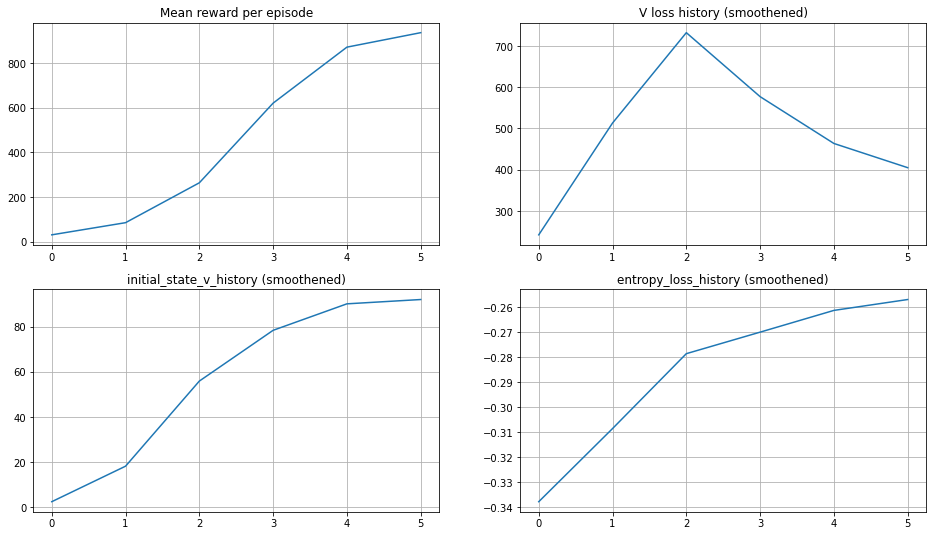

You Win!


In [19]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt
import utils

mean_rw_history = []
v_loss_history = []
entropy_loss_history = []
initial_state_v_history = []

for i in range(10):
    rewards, v_initial, entropy_losses, v_losses =  zip( *[train_on_session(*generate_session(env), entropy_coef=1.) for _ in range(10**2)] )   # generate new sessions
    
    mean_rw_history.append(np.mean(rewards))
    entropy_loss_history.append(np.mean(entropy_losses))
    v_loss_history.append(np.mean(v_losses))
    initial_state_v_history.append(np.mean(v_initial))
    
    
    clear_output(True)
    print("step:%i" % (i))

    plt.figure(figsize=[16, 9])

    plt.subplot(2, 2, 1)
    plt.title("Mean reward per episode")
    plt.plot(mean_rw_history)
    plt.grid()

    assert not np.isnan(v_loss_history[-1])
    plt.subplot(2, 2, 2)
    plt.title("V loss history (smoothened)")
    plt.plot(v_loss_history)
    plt.grid()

    plt.subplot(2, 2, 3)
    plt.title("initial_state_v_history (smoothened)")
    plt.plot(initial_state_v_history)
    plt.grid()

    plt.subplot(2, 2, 4)
    plt.title("entropy_loss_history (smoothened)")
    plt.plot(entropy_loss_history)
    plt.grid()

    plt.show()
    
    if np.mean(rewards) >= 900:
        print("You Win!")  # but you can train even further
        break

### Results & video

In [20]:
# Record sessions

import gym.wrappers

with gym.wrappers.Monitor(gym.make(env_name), directory="videos", force=True) as env_monitor:
    sessions = [generate_session(env_monitor) for _ in range(1)]

In [22]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

import sys
from pathlib import Path
from base64 import b64encode
from IPython.display import HTML

video_paths = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[-1]  # You can also try other indices

if 'google.colab' in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open('rb') as fp:
        mp4 = fp.read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))